In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from pathlib import Path

# 1. Cargar el archivo directamente con xarray para ver las tripas
file_path = "OR_ABI-L2-FDCF-M6_G19_s20260031200230_e20260031209539_c20260031210078.nc"
ds = xr.open_dataset(file_path)

print(f"--- Análisis del archivo FDCF ---")
print(f"Dimensiones: {ds.dims}")

# 2. Variables clave en FDCF
# Mask: Clasificación del pixel (fuego, nube, agua, etc)
# Power: FRP (Fire Radiative Power) en MW
# Temp: Temperatura del foco en Kelvin
variables_interes = ['Mask', 'Power', 'Temp', 'Area']

for var in variables_interes:
    data = ds[var].values
    # Quitamos los valores nulos/NaN para las estadísticas
    valid_data = data[~np.isnan(data)]
    
    if valid_data.size > 0:
        print(f"\nVariable: {var}")
        print(f"  - Valor Mín: {valid_data.min():.2f}")
        print(f"  - Valor Máx: {valid_data.max():.2f}")
        print(f"  - Media: {valid_data.mean():.2f}")
    else:
        print(f"\nVariable: {var} -> Sin detecciones en este archivo.")

# 3. Entendiendo la Máscara (Mask)
# Los valores de la máscara nos dicen qué detectó el algoritmo.
mask_values = ds['Mask'].values
unique, counts = np.unique(mask_values[~np.isnan(mask_values)], return_counts=True)
print("\n--- Conteo de Pixeles por Clasificación (Mask) ---")
for val, count in zip(unique, counts):
    print(f"  Valor {int(val)}: {count} píxeles")

--- Análisis del archivo FDCF ---
Dimensiones: FrozenMappingWarningOnValuesAccess({'y': 5424, 'x': 5424, 'number_of_time_bounds': 2, 'number_of_image_bounds': 2, 'number_of_sunglint_angle_bounds': 2, 'number_of_LZA_bounds': 2, 'number_of_SZA_bounds': 2})

Variable: Mask
  - Valor Mín: 10.00
  - Valor Máx: 245.00
  - Media: 133.65

Variable: Power
  - Valor Mín: 2.35
  - Valor Máx: 55.55
  - Media: 26.09

Variable: Temp
  - Valor Mín: 472.74
  - Valor Máx: 857.40
  - Media: 609.75

Variable: Area
  - Valor Mín: 4000.00
  - Valor Máx: 59430.82
  - Media: 12171.32

--- Conteo de Pixeles por Clasificación (Mask) ---
  Valor 10: 1 píxeles
  Valor 12: 1 píxeles
  Valor 13: 1 píxeles
  Valor 15: 6 píxeles
  Valor 30: 7 píxeles
  Valor 32: 1 píxeles
  Valor 33: 1 píxeles
  Valor 34: 1 píxeles
  Valor 40: 2959900 píxeles
  Valor 50: 705052 píxeles
  Valor 60: 212771 píxeles
  Valor 100: 2926540 píxeles
  Valor 126: 1011 píxeles
  Valor 127: 94 píxeles
  Valor 150: 16453028 píxeles
  Valor 151: 

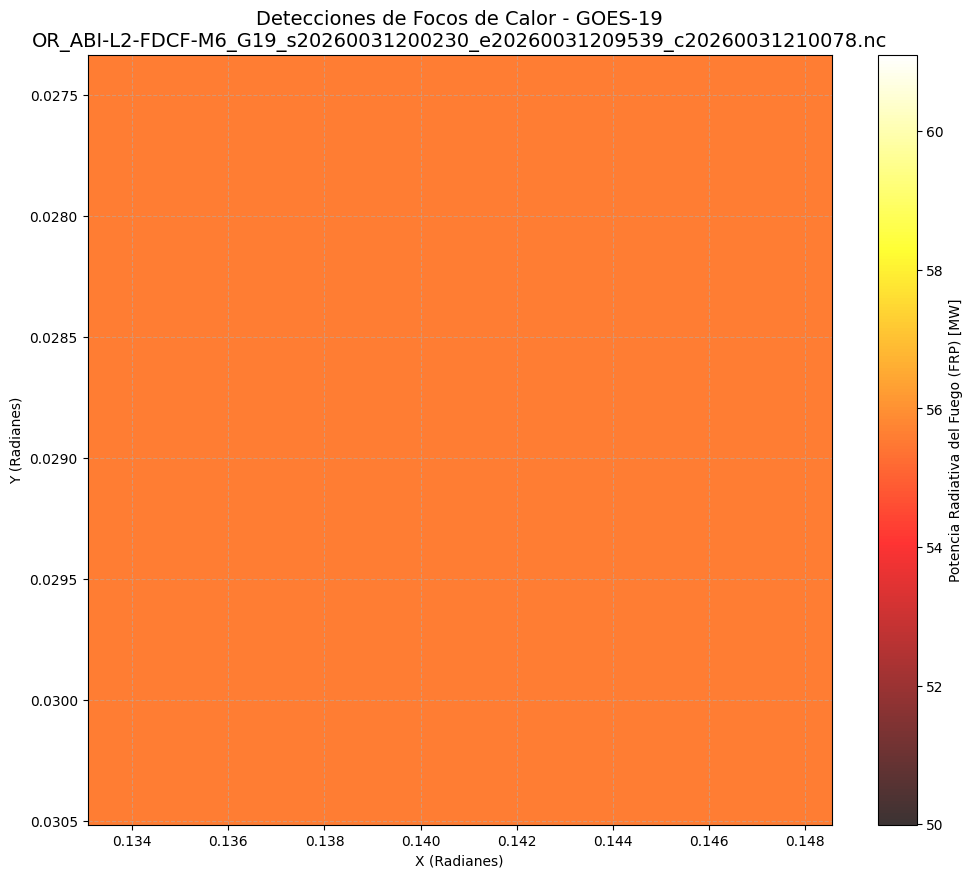

Se detectaron 9 focos de calor con alta confianza.


In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# 1. Cargar archivo
file_nc = "OR_ABI-L2-FDCF-M6_G19_s20260031200230_e20260031209539_c20260031210078.nc"
ds = xr.open_dataset(file_nc)

# 2. Filtrar píxeles con fuego (Máscara entre 10 y 15)
# Esto crea una matriz booleana para filtrar las demás variables
mask = ds.Mask.values
is_fire = (mask >= 10) & (mask <= 15)

# Extraer coordenadas de los fuegos (en radianes de la proyección satelital)
x_fire = ds.x.values[np.where(is_fire)[1]]
y_fire = ds.y.values[np.where(is_fire)[0]]

# Extraer Power (FRP) y Área para los puntos detectados
frp_fire = ds.Power.values[is_fire]
area_fire = ds.Area.values[is_fire]

# 3. Graficar
plt.figure(figsize=(12, 10))

# Graficamos los puntos detectados
# El color representa la potencia (FRP) y el tamaño el área
sc = plt.scatter(x_fire, y_fire, 
                 c=frp_fire, 
                 s=area_fire * 1000, # Escalamos el tamaño para que sea visible
                 cmap='hot', 
                 edgecolors='black', 
                 linewidths=0.5, 
                 alpha=0.8)

plt.colorbar(sc, label='Potencia Radiativa del Fuego (FRP) [MW]')
plt.title(f'Detecciones de Focos de Calor - GOES-19\n{ds.attrs["dataset_name"]}', fontsize=14)
plt.xlabel('X (Radianes)')
plt.ylabel('Y (Radianes)')
plt.grid(True, linestyle='--', alpha=0.5)

# Invertir eje Y porque en las imágenes satelitales el origen suele estar arriba
plt.gca().invert_yaxis() 

plt.show()

print(f"Se detectaron {len(x_fire)} focos de calor con alta confianza.")

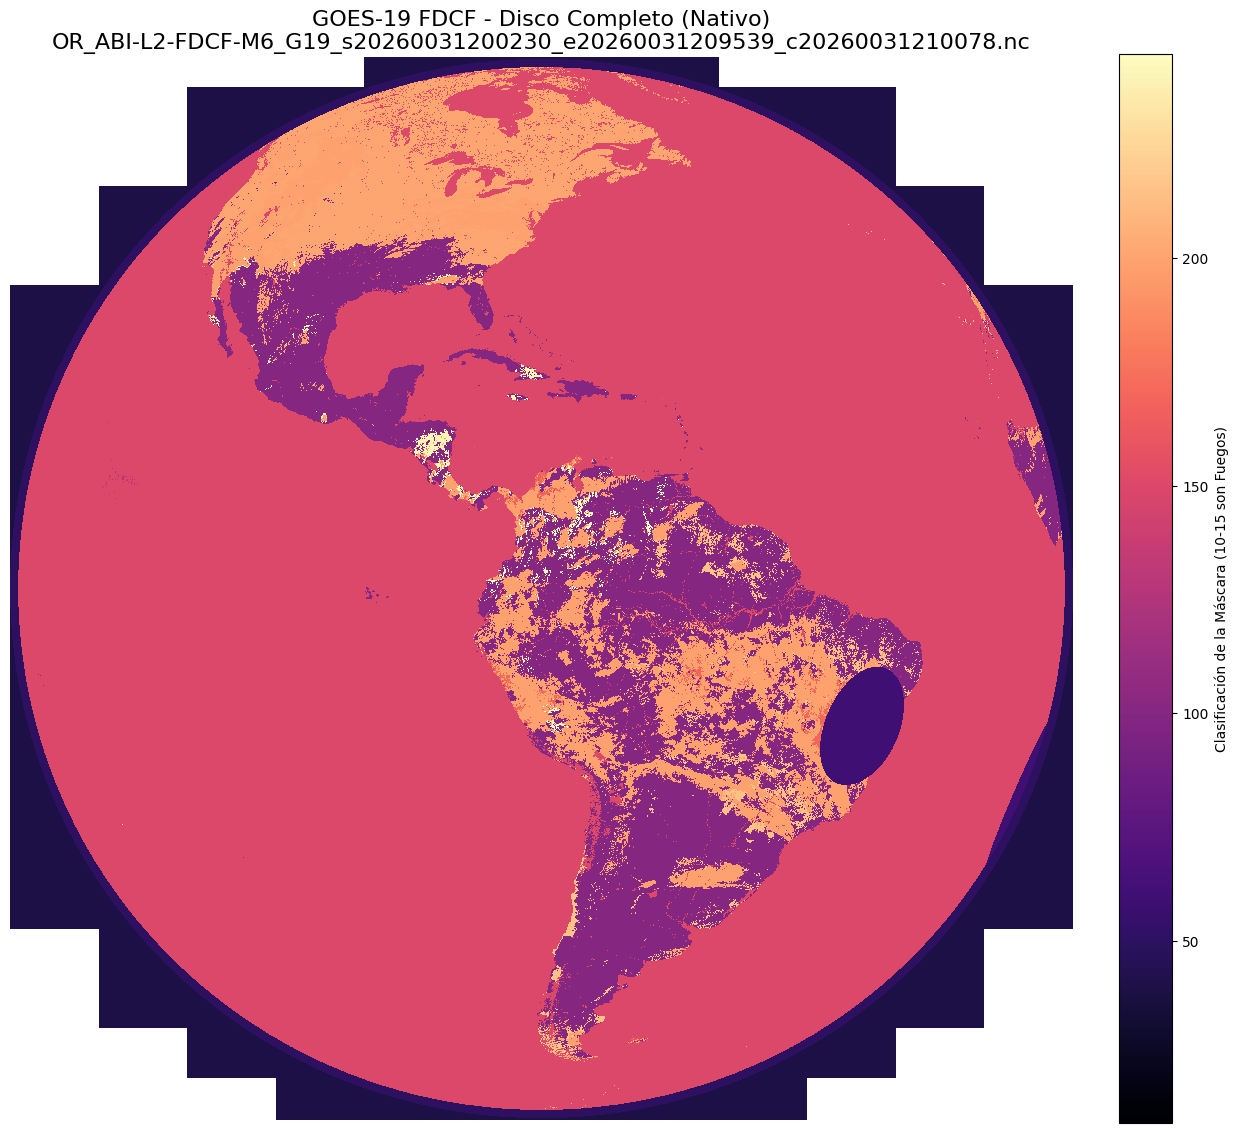

Análisis completado:
 - Píxeles totales procesados: 29,419,776
 - Focos de calor (fuego) encontrados: 9


In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# 1. Cargar el archivo
file_nc = "OR_ABI-L2-FDCF-M6_G19_s20260031200230_e20260031209539_c20260031210078.nc"
ds = xr.open_dataset(file_nc)

# 2. Extraer la máscara y limpiar valores nulos
# Usamos .where para que los valores de relleno (NaN) no afecten el color
mask_full = ds.Mask.astype(float)
mask_full = mask_full.where(mask_full != ds.Mask.attrs.get('_FillValue', 65535))

# 3. Plotear el disco completo
plt.figure(figsize=(15, 15))

# Usamos una paleta 'magma' o 'inferno' que resalta mucho los valores de fuego
# Los valores 10-15 (fuego) brillarán sobre el fondo oscuro
im = plt.imshow(mask_full, cmap='magma', interpolation='nearest')

plt.colorbar(im, label='Clasificación de la Máscara (10-15 son Fuegos)', fraction=0.046, pad=0.04)

# Título con metadatos del satélite
plt.title(f'GOES-19 FDCF - Disco Completo (Nativo)\n{ds.attrs["dataset_name"]}', fontsize=16)
plt.axis('off') # Quitamos los ejes para que parezca una imagen satelital pura

plt.show()

# 4. Resumen estadístico en consola
fuegos_detectados = np.sum((mask_full >= 10) & (mask_full <= 15)).values
print(f"Análisis completado:")
print(f" - Píxeles totales procesados: {mask_full.size:,}")
print(f" - Focos de calor (fuego) encontrados: {int(fuegos_detectados)}")

In [4]:
import pandas as pd
import numpy as np

# 1. Obtener los valores únicos y sus conteos
mask_values = ds.Mask.values
unique, counts = np.unique(mask_values[~np.isnan(mask_values)], return_counts=True)

# 2. Diccionario de significados (basado en el estándar de NOAA)
meanings = {
    0: "Suelo Despejado (Clear Land)",
    10: "Fuego: Confianza Alta (Good)",
    11: "Fuego: Saturado (Saturated)",
    12: "Fuego: Contaminado por Nubes",
    13: "Fuego: Probabilidad Alta",
    14: "Fuego: Probabilidad Media",
    15: "Fuego: Probabilidad Baja",
    30: "Nubes (Cloudy)",
    32: "Nubes Espesas / Probables",
    126: "Fuera de Disco / Espacio",
    127: "Dato Inválido / Relleno"
}

# 3. Crear un DataFrame para verlo bonito
df_stats = pd.DataFrame({
    'ID_Categoria': unique.astype(int),
    'Conteo_Pixeles': counts
})

# Mapear los nombres (si no está en el dict, pone "Otra Categoría")
df_stats['Descripcion'] = df_stats['ID_Categoria'].map(lambda x: meanings.get(x, "Otras Categorías / Superficies"))

# Calcular porcentaje del total de la imagen
df_stats['Porcentaje (%)'] = (df_stats['Conteo_Pixeles'] / mask_values.size * 100).round(4)

# Ordenar por importancia (fuegos primero)
print(f"--- RESUMEN DE CATEGORÍAS FDCF (G19) ---")
print(df_stats.sort_values(by='ID_Categoria').to_string(index=False))

# 4. Total de fuegos "seguros"
fuegos_seguros = df_stats[df_stats['ID_Categoria'].isin([10, 11])]['Conteo_Pixeles'].sum()
print(f"\n🔥 Total de focos de calor confirmados (Cat 10 y 11): {fuegos_seguros}")

--- RESUMEN DE CATEGORÍAS FDCF (G19) ---
 ID_Categoria  Conteo_Pixeles                    Descripcion  Porcentaje (%)
           10               1   Fuego: Confianza Alta (Good)          0.0000
           12               1   Fuego: Contaminado por Nubes          0.0000
           13               1       Fuego: Probabilidad Alta          0.0000
           15               6       Fuego: Probabilidad Baja          0.0000
           30               7                 Nubes (Cloudy)          0.0000
           32               1      Nubes Espesas / Probables          0.0000
           33               1 Otras Categorías / Superficies          0.0000
           34               1 Otras Categorías / Superficies          0.0000
           40         2959900 Otras Categorías / Superficies         10.0609
           50          705052 Otras Categorías / Superficies          2.3965
           60          212771 Otras Categorías / Superficies          0.7232
          100         2926540 Otras

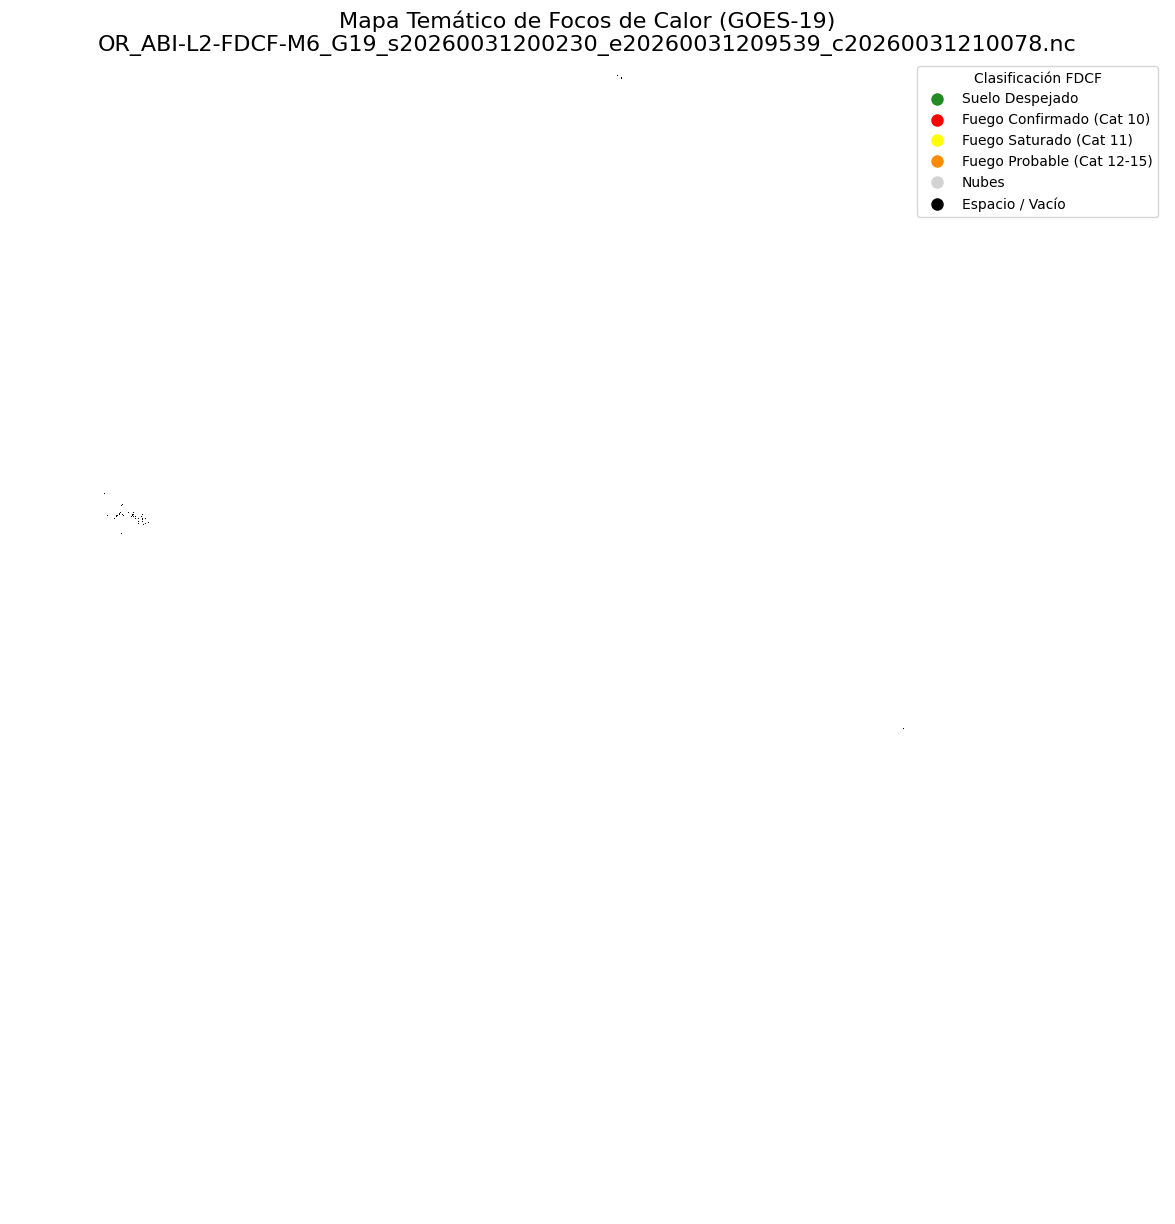

In [5]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import xarray as xr

# 1. Definir nuestro diccionario de colores (Categoria: Color)
# Simplificamos grupos para que el mapa sea legible
color_map_dict = {
    0:   '#228B22', # Suelo - Verde
    10:  '#FF0000', # Fuego Alta - Rojo
    11:  '#FFFF00', # Fuego Sat - Amarillo
    12:  '#FF8C00', # Fuego Nube - Naranja
    13:  '#FF8C00', # Fuego Prob - Naranja
    14:  '#FF8C00', # Fuego Prob - Naranja
    15:  '#FF8C00', # Fuego Prob - Naranja
    30:  '#D3D3D3', # Nubes - Gris
    32:  '#D3D3D3', # Nubes - Gris
    126: '#000000', # Espacio - Negro
    127: '#000000'  # Relleno - Negro
}

# 2. Preparar los datos
mask_data = ds.Mask.values.copy()

# Crear una imagen RGBA (Red, Green, Blue, Alpha) para pintar pixel por pixel
h, w = mask_data.shape
rgba_img = np.zeros((h, w, 4)) 

# Llenar la imagen con los colores definidos
for cat, color in color_map_dict.items():
    indices = np.where(mask_data == cat)
    rgba_img[indices] = mcolors.to_rgba(color)

# 3. Plotear
plt.figure(figsize=(15, 15))
plt.imshow(rgba_img, interpolation='nearest')

# Crear una leyenda personalizada
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Suelo Despejado', markerfacecolor='#228B22', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Fuego Confirmado (Cat 10)', markerfacecolor='#FF0000', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Fuego Saturado (Cat 11)', markerfacecolor='#FFFF00', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Fuego Probable (Cat 12-15)', markerfacecolor='#FF8C00', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Nubes', markerfacecolor='#D3D3D3', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Espacio / Vacío', markerfacecolor='#000000', markersize=10)
]

plt.legend(handles=legend_elements, loc='upper right', title="Clasificación FDCF")
plt.title(f"Mapa Temático de Focos de Calor (GOES-19)\n{ds.attrs['dataset_name']}", fontsize=16)
plt.axis('off')
plt.show()

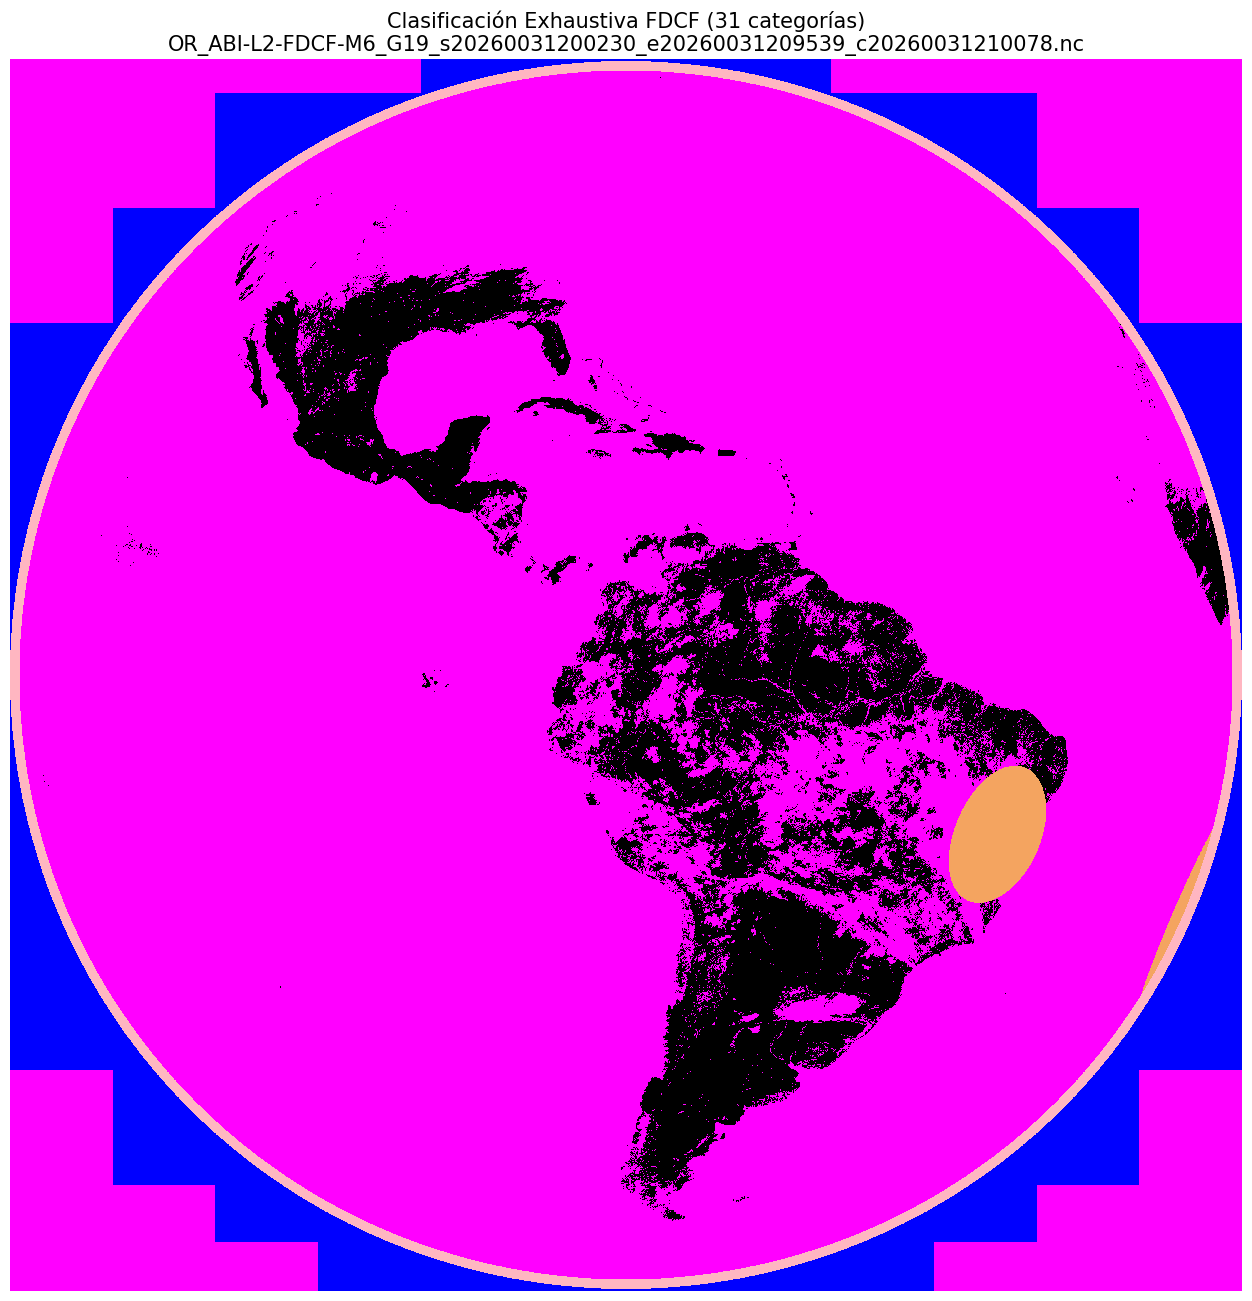

In [6]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import xarray as xr

# 1. Definir el mapa de colores para las categorías oficiales
# Usamos un diccionario completo basado en el manual de NOAA
full_mask_colors = {
    0:   '#228B22', # Clear land
    10:  '#FF0000', # Good fire
    11:  '#FFFF00', # Saturated fire
    12:  '#FF8C00', # Cloud contaminated fire
    13:  '#FF1493', # High prob fire
    14:  '#FA8072', # Medium prob fire
    15:  '#A52A2A', # Low prob fire
    30:  '#D3D3D3', # Cloud
    31:  '#A9A9A9', # Cloud-edge
    32:  '#808080', # Probable cloud
    33:  '#F0F8FF', # Fire-free cloud
    34:  '#F5F5F5', # Thin cloud
    35:  '#F0E68C', # High solar zenith
    40:  '#0000FF', # Water
    50:  '#FFB6C1', # Glint (reflejo sol)
    60:  '#F4A460', # Desert
    100: '#000000', 120: '#000000', 121: '#000000', 
    123: '#000000', 124: '#000000', 125: '#000000',
    126: '#000000', 127: '#000000'
}

# 2. Procesar la imagen
mask_data = ds.Mask.values
h, w = mask_data.shape
rgba_img = np.zeros((h, w, 4))

# Color por defecto para cualquier categoría no mapeada (Magenta fuerte para que resalte)
rgba_img[:] = mcolors.to_rgba('#FF00FF') 

# Mapeo exhaustivo
for val, color in full_mask_colors.items():
    rgba_img[np.where(mask_data == val)] = mcolors.to_rgba(color)

# 3. Visualización
plt.figure(figsize=(16, 16))
plt.imshow(rgba_img, interpolation='nearest')

plt.title(f"Clasificación Exhaustiva FDCF (31 categorías)\n{ds.attrs['dataset_name']}", fontsize=15)
plt.axis('off')

# Nota: No ponemos leyenda de las 31 porque ocuparía toda la pantalla, 
# pero puedes consultar el diccionario 'full_mask_colors' arriba.
plt.show()

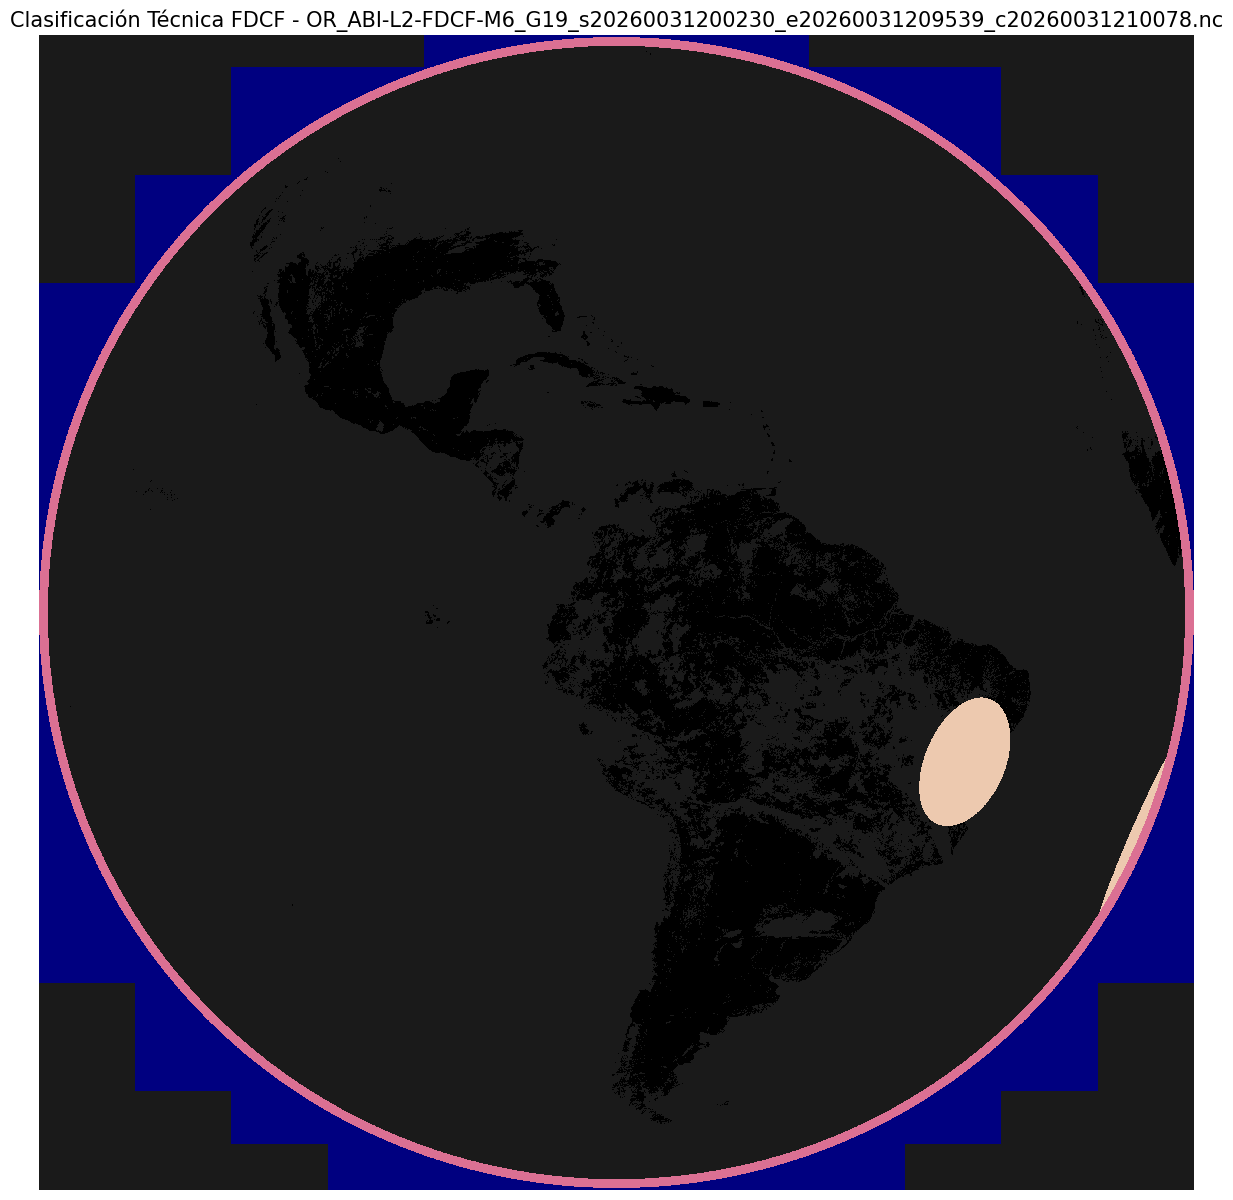

In [7]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import xarray as xr

# 1. Diccionario Maestro de 31 Categorías: Código, Color y Definición Técnica
# Este diccionario sirve como referencia central para tu procesador FDCF
fdcf_metadata = {
    # --- GRUPO: SUPERFICIE DESPEJADA ---
    0:   {'color': '#228B22', 'desc': 'Suelo libre de fuego y nubes (Area Clear)'},
    
    # --- GRUPO: DETECCIONES DE FUEGO (CONFIRMADOS) ---
    10:  {'color': '#8B0000', 'desc': 'Fuego de alta fidelidad (Good Quality)'},
    11:  {'color': '#FF0000', 'desc': 'Fuego saturado (Saturated - Muy intenso)'},
    12:  {'color': '#FF4500', 'desc': 'Fuego detectado a través de nubes delgadas'},
    
    # --- GRUPO: DETECCIONES DE FUEGO (PROBABILÍSTICOS) ---
    13:  {'color': '#FF8C00', 'desc': 'Fuego de alta probabilidad (FRP confiable)'},
    14:  {'color': '#FFD700', 'desc': 'Fuego de probabilidad media'},
    15:  {'color': '#FFFF00', 'desc': 'Fuego de baja probabilidad (Posible falso positivo)'},
    
    # --- GRUPO: CATEGORÍAS RESERVADAS (INVESTIGACIÓN) ---
    16:  {'color': '#8A2BE2', 'desc': 'Reservado para futuras versiones 1'},
    17:  {'color': '#800080', 'desc': 'Reservado para futuras versiones 2'},
    18:  {'color': '#4B0082', 'desc': 'Reservado para futuras versiones 3'},
    19:  {'color': '#FF00FF', 'desc': 'Reservado para futuras versiones 4'},
    20:  {'color': '#DA70D6', 'desc': 'Reservado para futuras versiones 5'},
    21:  {'color': '#DDA0DD', 'desc': 'Reservado para futuras versiones 6'},
    22:  {'color': '#D8BFD8', 'desc': 'Reservado para futuras versiones 7'},
    
    # --- GRUPO: NUBOSIDAD (BLOQUEO DE VISIÓN) ---
    30:  {'color': '#FFFFFF', 'desc': 'Nube detectada (Cloud)'},
    31:  {'color': '#F5F5F5', 'desc': 'Borde de nube (Cloud edge)'},
    32:  {'color': '#DCDCDC', 'desc': 'Nube probable (Probable cloud)'},
    33:  {'color': '#E5E4E2', 'desc': 'Nube libre de fuego (Fire-free cloud)'},
    34:  {'color': '#B2BEB5', 'desc': 'Nube delgada (Thin cloud)'},
    35:  {'color': '#F0E68C', 'desc': 'Ángulo solar alto (Dato no confiable por posición del sol)'},
    
    # --- GRUPO: OTRAS SUPERFICIES ---
    40:  {'color': '#000080', 'desc': 'Superficie de agua (Cuerpos de agua/Océano)'},
    50:  {'color': '#DB7093', 'desc': 'Reflejo solar detectado (Solar Glint)'},
    60:  {'color': '#EDC9AF', 'desc': 'Superficie desértica (Alta reflectividad térmica)'},
    
    # --- GRUPO: ERRORES E INVÁLIDOS ---
    100: {'color': '#000000', 'desc': 'Dato faltante (Missing L1b)'},
    120: {'color': '#121212', 'desc': 'Dato corrupto (Bad L1b)'},
    121: {'color': '#2F4F4F', 'desc': 'Píxel extremadamente nublado (Inválido)'},
    123: {'color': '#0B0B0B', 'desc': 'Valor fuera de rango (Out of range)'},
    124: {'color': '#0F0F0F', 'desc': 'Error de calibración del sensor'},
    125: {'color': '#050505', 'desc': 'Píxel no procesado por el algoritmo'},
    126: {'color': '#000000', 'desc': 'Fuera del área de escaneo (Espacio)'},
    127: {'color': '#000000', 'desc': 'Valor de relleno (Fill Value)'}
}

# 2. Preparar la imagen RGBA
mask_data = ds.Mask.values
h, w = mask_data.shape
rgba_img = np.zeros((h, w, 4))

# Color base (Gris muy oscuro para lo que no esté en la lista)
rgba_img[:] = mcolors.to_rgba('#1A1A1A')

# 3. Aplicar colores iterando sobre el diccionario documentado
for code, info in fdcf_metadata.items():
    mask_indices = (mask_data == code)
    rgba_img[mask_indices] = mcolors.to_rgba(info['color'])

# 4. Plotear
plt.figure(figsize=(15, 15))
plt.imshow(rgba_img, interpolation='nearest')
plt.title(f"Clasificación Técnica FDCF - {ds.attrs.get('dataset_name', 'GOES-19')}", fontsize=15)
plt.axis('off')
plt.show()

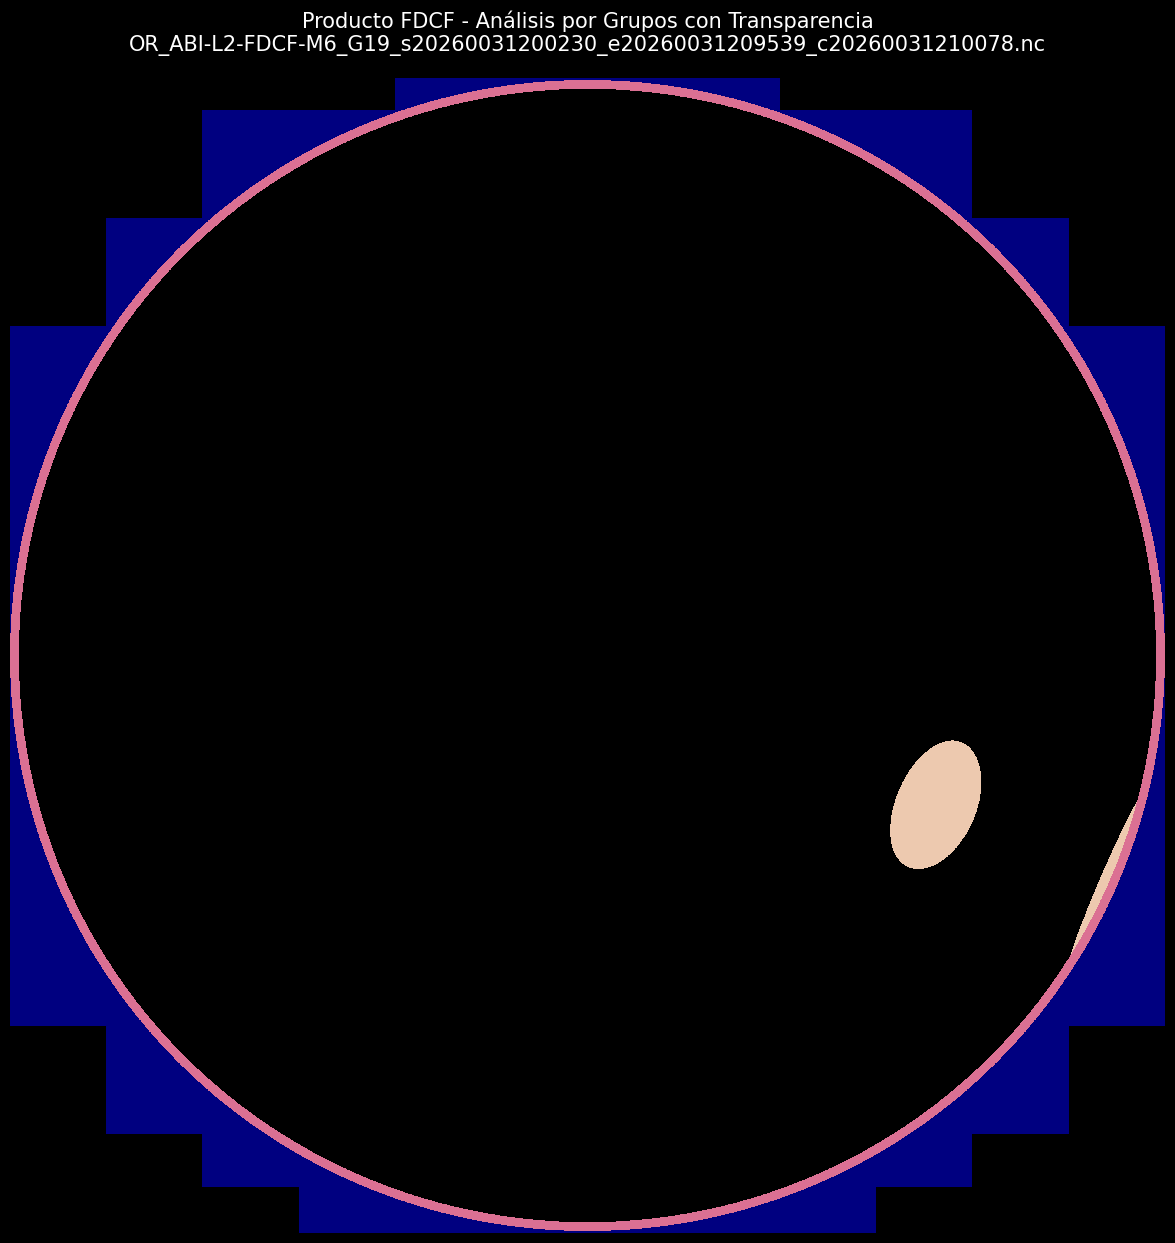

In [8]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import xarray as xr

# 1. DICCIONARIO MAESTRO CON GRUPOS DETALLADOS
fdcf_metadata = {
    # --- GRUPO: SUPERFICIE DESPEJADA ---
    0:   {'color': '#228B22', 'desc': 'Suelo libre de fuego (Area Clear)'},
    
    # --- GRUPO: DETECCIONES DE FUEGO (CONFIRMADOS) ---
    10:  {'color': '#8B0000', 'desc': 'Fuego: Alta fidelidad (Good)'},
    11:  {'color': '#FF0000', 'desc': 'Fuego: Saturado (Muy intenso)'},
    12:  {'color': '#FF4500', 'desc': 'Fuego: Tras nubes delgadas'},
    
    # --- GRUPO: DETECCIONES DE FUEGO (PROBABILÍSTICOS) ---
    13:  {'color': '#FF8C00', 'desc': 'Fuego: Probabilidad alta'},
    14:  {'color': '#FFD700', 'desc': 'Fuego: Probabilidad media'},
    15:  {'color': '#FFFF00', 'desc': 'Fuego: Probabilidad baja'},
    
    # --- GRUPO: CATEGORÍAS RESERVADAS (INVESTIGACIÓN) ---
    16:  {'color': '#8A2BE2', 'desc': 'Reservado 1'},
    17:  {'color': '#800080', 'desc': 'Reservado 2'},
    18:  {'color': '#4B0082', 'desc': 'Reservado 3'},
    19:  {'color': '#FF00FF', 'desc': 'Reservado 4'},
    20:  {'color': '#DA70D6', 'desc': 'Reservado 5'},
    21:  {'color': '#DDA0DD', 'desc': 'Reservado 6'},
    22:  {'color': '#D8BFD8', 'desc': 'Reservado 7'},
    
    # --- GRUPO: NUBOSIDAD ---
    30:  {'color': '#FFFFFF', 'desc': 'Nube detectada'},
    31:  {'color': '#F5F5F5', 'desc': 'Borde de nube'},
    32:  {'color': '#DCDCDC', 'desc': 'Nube probable'},
    33:  {'color': '#E5E4E2', 'desc': 'Nube libre de fuego'},
    34:  {'color': '#B2BEB5', 'desc': 'Nube delgada'},
    35:  {'color': '#F0E68C', 'desc': 'Ángulo solar alto (Dato pobre)'},
    
    # --- GRUPO: OTRAS SUPERFICIES ---
    40:  {'color': '#000080', 'desc': 'Cuerpos de agua'},
    50:  {'color': '#DB7093', 'desc': 'Reflejo solar (Glint)'},
    60:  {'color': '#EDC9AF', 'desc': 'Desierto'},
    
    # --- GRUPO: ERRORES E INVÁLIDOS ---
    100: {'color': '#000000', 'desc': 'Falta L1b'},
    120: {'color': '#121212', 'desc': 'Dato L1b corrupto'},
    121: {'color': '#2F4F4F', 'desc': 'Extremadamente nublado'},
    123: {'color': '#0B0B0B', 'desc': 'Fuera de rango térmico'},
    124: {'color': '#0F0F0F', 'desc': 'Error de calibración'},
    125: {'color': '#050505', 'desc': 'Píxel no procesado'},
    126: {'color': '#000000', 'desc': 'Fuera de escaneo (Espacio)'},
    127: {'color': '#000000', 'desc': 'Valor de relleno (Fill)'}
}

# --- 2. CONFIGURACIÓN DE TRANSPARENCIA ---
# Aquí defines qué grupos quieres "apagar" para limpiar la imagen
categorias_transparentes = [30, 31, 32, 33, 34, 35, 100, 120, 121, 123, 124, 125, 126, 127]

# 3. PROCESAMIENTO DE LA IMAGEN RGBA
mask_data = ds.Mask.values
h, w = mask_data.shape
rgba_img = np.zeros((h, w, 4)) 

for code, info in fdcf_metadata.items():
    mask_indices = (mask_data == code)
    
    # Extraer color RGB del Hex
    rgb = mcolors.to_rgb(info['color'])
    
    # Determinar opacidad (0.0 invisible, 1.0 opaco)
    alpha = 0.0 if code in categorias_transparentes else 1.0
    
    # Asignar al array (R, G, B, A)
    rgba_img[mask_indices] = [*rgb, alpha]

# 4. VISUALIZACIÓN
plt.figure(figsize=(15, 15), facecolor='black')
plt.imshow(rgba_img, interpolation='nearest')
plt.title(f"Producto FDCF - Análisis por Grupos con Transparencia\n{ds.attrs.get('dataset_name', 'G19')}", 
          fontsize=15, color='white', pad=20)
plt.axis('off')
plt.show()

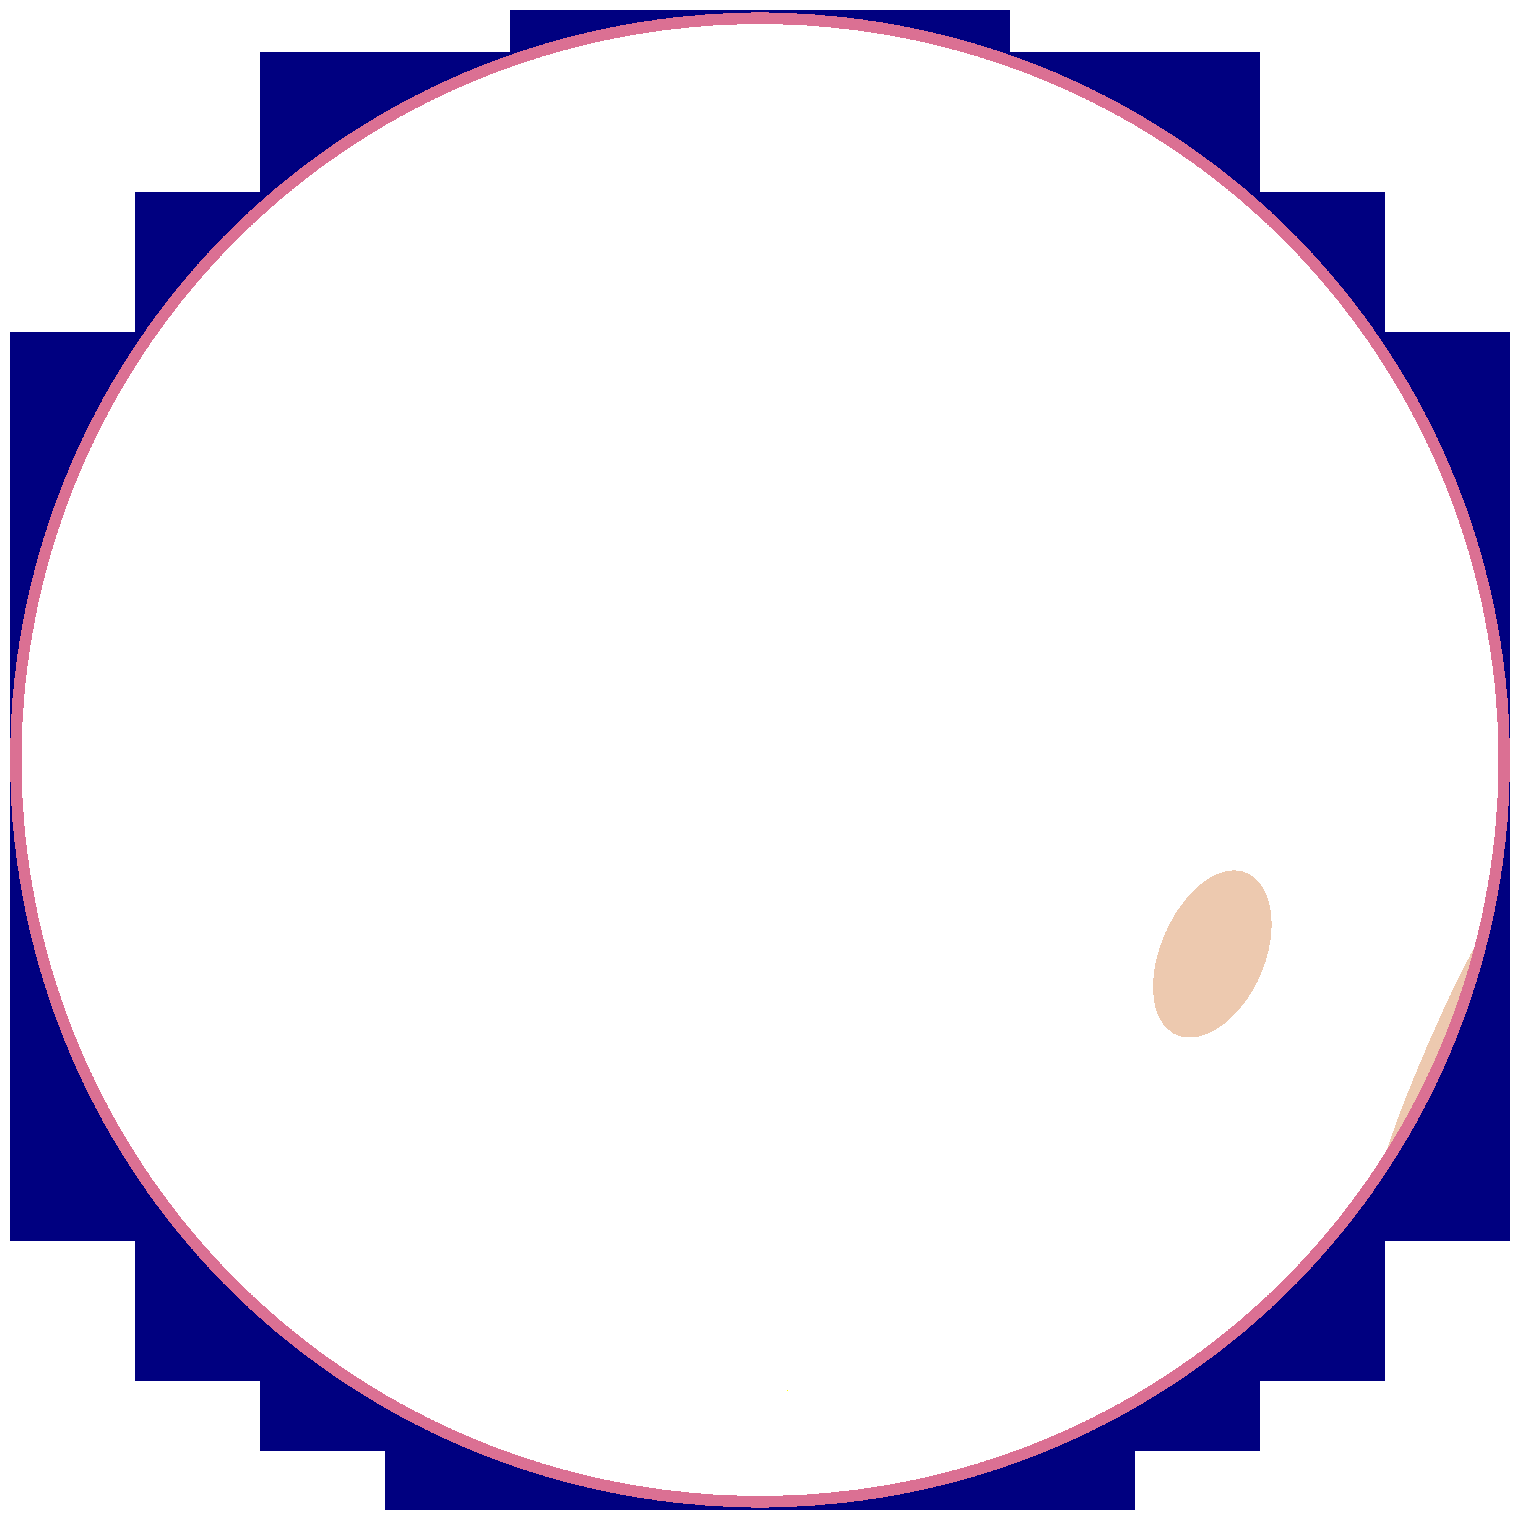

In [9]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# 1. DICCIONARIO MAESTRO CON GRUPOS DETALLADOS
fdcf_metadata = {
    # --- GRUPO: SUPERFICIE DESPEJADA ---
    0:   {'color': '#228B22', 'desc': 'Suelo libre de fuego (Area Clear)'},
    
    # --- GRUPO: DETECCIONES DE FUEGO (CONFIRMADOS) ---
    10:  {'color': '#8B0000', 'desc': 'Fuego: Alta fidelidad (Good)'},
    11:  {'color': '#FF0000', 'desc': 'Fuego: Saturado (Muy intenso)'},
    12:  {'color': '#FF4500', 'desc': 'Fuego: Tras nubes delgadas'},
    
    # --- GRUPO: DETECCIONES DE FUEGO (PROBABILÍSTICOS) ---
    13:  {'color': '#FF8C00', 'desc': 'Fuego: Probabilidad alta'},
    14:  {'color': '#FFD700', 'desc': 'Fuego: Probabilidad media'},
    15:  {'color': '#FFFF00', 'desc': 'Fuego: Probabilidad baja'},
    
    # --- GRUPO: CATEGORÍAS RESERVADAS (INVESTIGACIÓN) ---
    16:  {'color': '#8A2BE2', 'desc': 'Reservado 1'},
    17:  {'color': '#800080', 'desc': 'Reservado 2'},
    18:  {'color': '#4B0082', 'desc': 'Reservado 3'},
    19:  {'color': '#FF00FF', 'desc': 'Reservado 4'},
    20:  {'color': '#DA70D6', 'desc': 'Reservado 5'},
    21:  {'color': '#DDA0DD', 'desc': 'Reservado 6'},
    22:  {'color': '#D8BFD8', 'desc': 'Reservado 7'},
    
    # --- GRUPO: NUBOSIDAD ---
    30:  {'color': '#FFFFFF', 'desc': 'Nube detectada'},
    31:  {'color': '#F5F5F5', 'desc': 'Borde de nube'},
    32:  {'color': '#DCDCDC', 'desc': 'Nube probable'},
    33:  {'color': '#E5E4E2', 'desc': 'Nube libre de fuego'},
    34:  {'color': '#B2BEB5', 'desc': 'Nube delgada'},
    35:  {'color': '#F0E68C', 'desc': 'Ángulo solar alto (Dato pobre)'},
    
    # --- GRUPO: OTRAS SUPERFICIES ---
    40:  {'color': '#000080', 'desc': 'Cuerpos de agua'},
    50:  {'color': '#DB7093', 'desc': 'Reflejo solar (Glint)'},
    60:  {'color': '#EDC9AF', 'desc': 'Desierto'},
    
    # --- GRUPO: ERRORES E INVÁLIDOS ---
    100: {'color': '#000000', 'desc': 'Falta L1b'},
    120: {'color': '#121212', 'desc': 'Dato L1b corrupto'},
    121: {'color': '#2F4F4F', 'desc': 'Extremadamente nublado'},
    123: {'color': '#0B0B0B', 'desc': 'Fuera de rango térmico'},
    124: {'color': '#0F0F0F', 'desc': 'Error de calibración'},
    125: {'color': '#050505', 'desc': 'Píxel no procesado'},
    126: {'color': '#000000', 'desc': 'Fuera de escaneo (Espacio)'},
    127: {'color': '#000000', 'desc': 'Valor de relleno (Fill)'}
}

# --- 2. CONFIGURACIÓN DE TRANSPARENCIA ---
# Agregué las nubes y los errores a esta lista
categorias_transparentes = [30, 31, 32, 33, 34, 35, 100, 120, 121, 123, 124, 125, 126, 127]

# 3. PROCESAMIENTO RGBA
mask_data = ds.Mask.values
h, w = mask_data.shape
rgba_img = np.zeros((h, w, 4), dtype=np.float32) 

for code, info in fdcf_metadata.items():
    mask_indices = (mask_data == code)
    rgb = mcolors.to_rgb(info['color'])
    
    # Si está en la lista de transparentes, Alpha = 0.0
    alpha = 0.0 if code in categorias_transparentes else 1.0
    rgba_img[mask_indices] = [*rgb, alpha]

# 4. PLOT PURO (SIN TÍTULOS NI EJES)
fig, ax = plt.subplots(figsize=(15, 15))

# IMPORTANTE: Configuramos el fondo del eje como transparente
ax.patch.set_alpha(0.0)

ax.imshow(rgba_img, interpolation='nearest')

# Eliminar absolutamente todo el marco
ax.axis('off')
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

plt.show()

In [21]:
from satpy import Scene
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# 1. Cargar el archivo
filenames = ["OR_ABI-L2-FDCF-M6_G19_s20260031200230_e20260031209539_c20260031210078.nc"]
scn = Scene(reader="abi_l2_nc", filenames=filenames)
scn.load(['Mask'])
mask = scn['Mask']

# 2. Diccionario Maestro (31 Categorías)
fdcf_metadata = {
    # --- GRUPO: SUPERFICIE DESPEJADA ---
    0:   {'color': '#228B22', 'desc': 'Suelo libre de fuego'},
    # --- GRUPO: DETECCIONES DE FUEGO (CONFIRMADOS) ---
    10:  {'color': '#8B0000', 'desc': 'Fuego: Alta fidelidad'},
    11:  {'color': '#FF0000', 'desc': 'Fuego: Saturado'},
    12:  {'color': '#FF4500', 'desc': 'Fuego: Tras nubes'},
    # --- GRUPO: DETECCIONES DE FUEGO (PROBABILÍSTICOS) ---
    13:  {'color': '#FF8C00', 'desc': 'Fuego: Probabilidad alta'},
    14:  {'color': '#FFD700', 'desc': 'Fuego: Probabilidad media'},
    15:  {'color': '#FFFF00', 'desc': 'Fuego: Probabilidad baja'},
    # --- GRUPO: RESERVADAS ---
    16: {'color':'#8A2BE2'}, 17: {'color':'#800080'}, 18: {'color':'#4B0082'}, 
    19: {'color':'#FF00FF'}, 20: {'color':'#DA70D6'}, 21: {'color':'#DDA0DD'}, 22: {'color':'#D8BFD8'},
    # --- GRUPO: NUBOSIDAD ---
    30:  {'color': '#FFFFFF', 'desc': 'Nube'},
    31:  {'color': '#F5F5F5', 'desc': 'Borde de nube'},
    32:  {'color': '#DCDCDC', 'desc': 'Nube probable'},
    33:  {'color': '#E5E4E2', 'desc': 'Nube sin fuego'},
    34:  {'color': '#B2BEB5', 'desc': 'Nube delgada'},
    35:  {'color': '#F0E68C', 'desc': 'Ángulo solar alto'},
    # --- GRUPO: OTRAS SUPERFICIES ---
    40:  {'color': '#000080', 'desc': 'Agua'},
    50:  {'color': '#DB7093', 'desc': 'Glint'},
    60:  {'color': '#EDC9AF', 'desc': 'Desierto'},
    # --- GRUPO: ERRORES ---
    100: {'color': '#000000'}, 120: {'color': '#121212'}, 121: {'color': '#2F4F4F'},
    123: {'color': '#0B0B0B'}, 124: {'color': '#0F0F0F'}, 125: {'color': '#050505'},
    126: {'color': '#000000'}, 127: {'color': '#000000'}
}

# 3. Categorías Transparentes
categorias_transparentes = [30, 31, 32, 33, 34, 35, 100, 120, 121, 123, 124, 125, 126, 127]

# 4. Construcción de la imagen RGBA
r = xr.zeros_like(mask, dtype=np.float32)
g = xr.zeros_like(mask, dtype=np.float32)
b = xr.zeros_like(mask, dtype=np.float32)
a = xr.zeros_like(mask, dtype=np.float32)

from matplotlib.colors import to_rgb
for code, info in fdcf_metadata.items():
    rgb = to_rgb(info['color'])
    idx = (mask == code)
    r = r.where(~idx, rgb[0])
    g = g.where(~idx, rgb[1])
    b = b.where(~idx, rgb[2])
    if code not in categorias_transparentes:
        a = a.where(~idx, 1.0)

rgba = xr.concat([r, g, b, a], dim='bands')
rgba.coords['bands'] = ['R', 'G', 'B', 'A']

# 5. Visualización Alternativa (Sin 'satpy.visualize')
# Usamos trollimage, que es lo que satpy usa por dentro
from trollimage.xrimage import XRImage
img = XRImage(rgba)

# Esto te mostrará la imagen en la notebook respetando el Alpha
img.show()

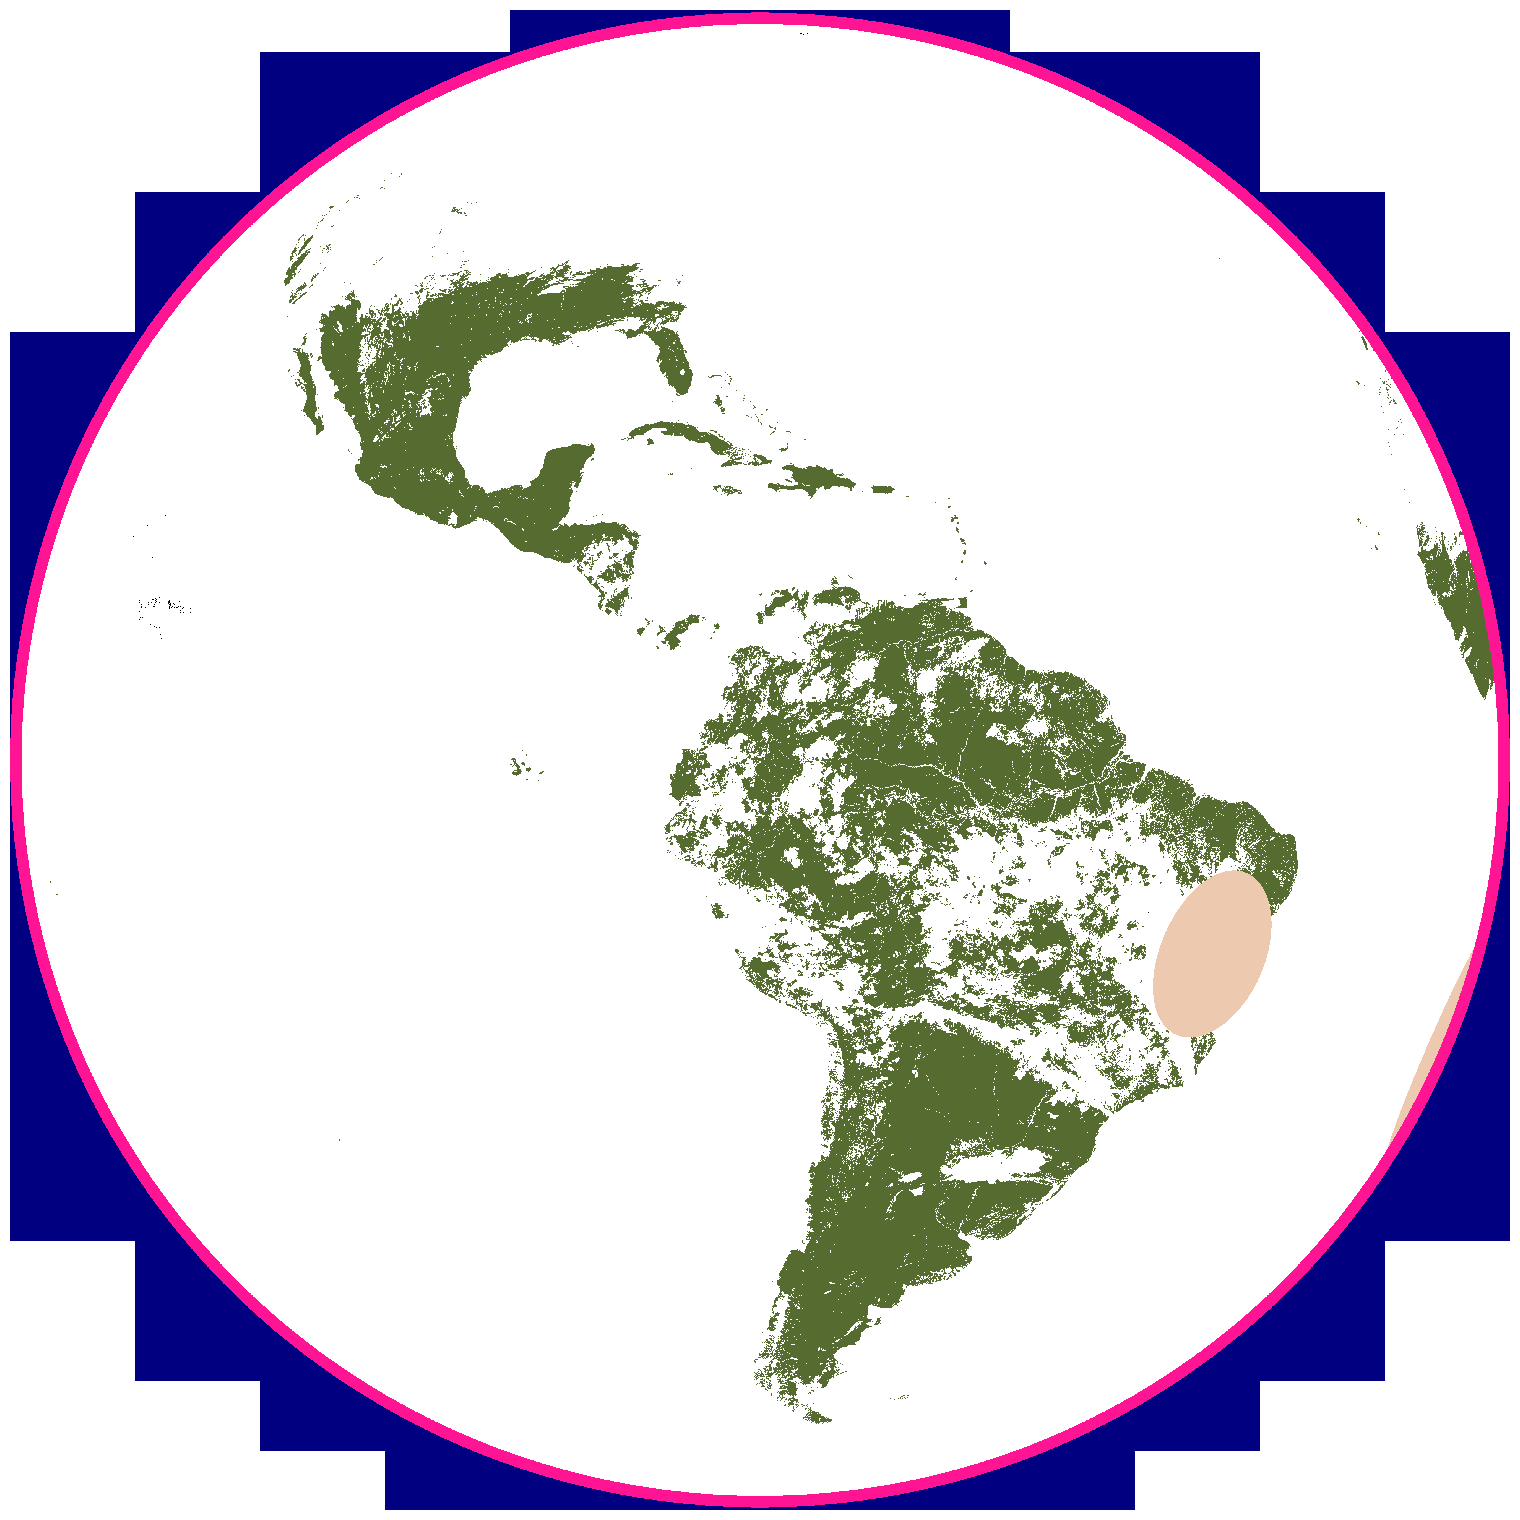

In [11]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# 1. DICCIONARIO MAESTRO CON 31 COLORES ÚNICOS
# He seleccionado colores específicos para que no se solapen visualmente
fdcf_metadata = {
    # --- GRUPO: SUPERFICIE DESPEJADA ---
    0:   {'color': '#228B22', 'desc': 'Suelo libre de fuego (Verde Bosque)'},
    
    # --- GRUPO: DETECCIONES DE FUEGO (CONFIRMADOS) ---
    10:  {'color': '#8B0000', 'desc': 'Fuego: Alta fidelidad (Granate)'},
    11:  {'color': '#FF0000', 'desc': 'Fuego: Saturado (Rojo Puro)'},
    12:  {'color': '#FF4500', 'desc': 'Fuego: Tras nubes (Naranja Rojizo)'},
    
    # --- GRUPO: DETECCIONES DE FUEGO (PROBABILÍSTICOS) ---
    13:  {'color': '#FF8C00', 'desc': 'Fuego: Probabilidad alta (Naranja Oscuro)'},
    14:  {'color': '#FFD700', 'desc': 'Fuego: Probabilidad media (Oro)'},
    15:  {'color': '#FFFF00', 'desc': 'Fuego: Probabilidad baja (Amarillo)'},
    
    # --- GRUPO: CATEGORÍAS RESERVADAS (INVESTIGACIÓN - Tonos Púrpura/Rosa) ---
    16:  {'color': '#8A2BE2', 'desc': 'Reservado 1 (Azul Violeta)'},
    17:  {'color': '#800080', 'desc': 'Reservado 2 (Púrpura)'},
    18:  {'color': '#4B0082', 'desc': 'Reservado 3 (Índigo)'},
    19:  {'color': '#FF00FF', 'desc': 'Reservado 4 (Magenta)'},
    20:  {'color': '#DA70D6', 'desc': 'Reservado 5 (Orquídea)'},
    21:  {'color': '#DDA0DD', 'desc': 'Reservado 6 (Ciruela)'},
    22:  {'color': '#D8BFD8', 'desc': 'Reservado 7 (Cardo)'},
    
    # --- GRUPO: NUBOSIDAD (Tonos de Blanco a Cian) ---
    30:  {'color': '#FFFFFF', 'desc': 'Nube detectada (Blanco)'},
    31:  {'color': '#E0FFFF', 'desc': 'Borde de nube (Cian Claro)'},
    32:  {'color': '#AFEEEE', 'desc': 'Nube probable (Turquesa Pálido)'},
    33:  {'color': '#ADD8E6', 'desc': 'Nube sin fuego (Azul Claro)'},
    34:  {'color': '#B0C4DE', 'desc': 'Nube delgada (Azul Acero)'},
    35:  {'color': '#F0E68C', 'desc': 'Ángulo solar alto (Caqui)'},
    
    # --- GRUPO: OTRAS SUPERFICIES ---
    40:  {'color': '#000080', 'desc': 'Cuerpos de agua (Azul Marino)'},
    50:  {'color': '#FF1493', 'desc': 'Reflejo solar (Rosa Profundo)'},
    60:  {'color': '#EDC9AF', 'desc': 'Desierto (Arena)'},
    
    # --- GRUPO: ERRORES E INVÁLIDOS (Escala de Grises y Marrones) ---
    100: {'color': '#556B2F', 'desc': 'Falta L1b (Verde Oliva Oscuro)'},
    120: {'color': '#808000', 'desc': 'Dato L1b corrupto (Oliva)'},
    121: {'color': '#2F4F4F', 'desc': 'Extremadamente nublado (Gris Pizarra)'},
    123: {'color': '#708090', 'desc': 'Fuera de rango térmico (Gris)'},
    124: {'color': '#A9A9A9', 'desc': 'Error de calibración (Gris Oscuro)'},
    125: {'color': '#696969', 'desc': 'Píxel no procesado (Gris Dim)'},
    126: {'color': '#000000', 'desc': 'Fuera de escaneo (Negro)'},
    127: {'color': '#1A1A1A', 'desc': 'Valor de relleno (Gris Casi Negro)'}
}

# --- 2. CONFIGURACIÓN DE TRANSPARENCIA ---
# Si quieres ver TODO, deja esta lista vacía: []
# Si quieres ocultar algo, añade el código aquí.
categorias_transparentes = [] 

# 3. PROCESAMIENTO RGBA
mask_data = ds.Mask.values
h, w = mask_data.shape
rgba_img = np.zeros((h, w, 4), dtype=np.float32) 

for code, info in fdcf_metadata.items():
    mask_indices = (mask_data == code)
    rgb = mcolors.to_rgb(info['color'])
    
    # Lógica de Alpha
    alpha = 0.0 if code in categorias_transparentes else 1.0
    rgba_img[mask_indices] = [*rgb, alpha]

# 4. PLOT TÉCNICO
fig, ax = plt.subplots(figsize=(15, 15))
ax.patch.set_alpha(0.0)
ax.imshow(rgba_img, interpolation='nearest')

ax.axis('off')
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

plt.show()

📏 Resolución original: 5424x5424 píxeles
👇 Imagen renderizada a tamaño real (usa el scroll si es necesario):


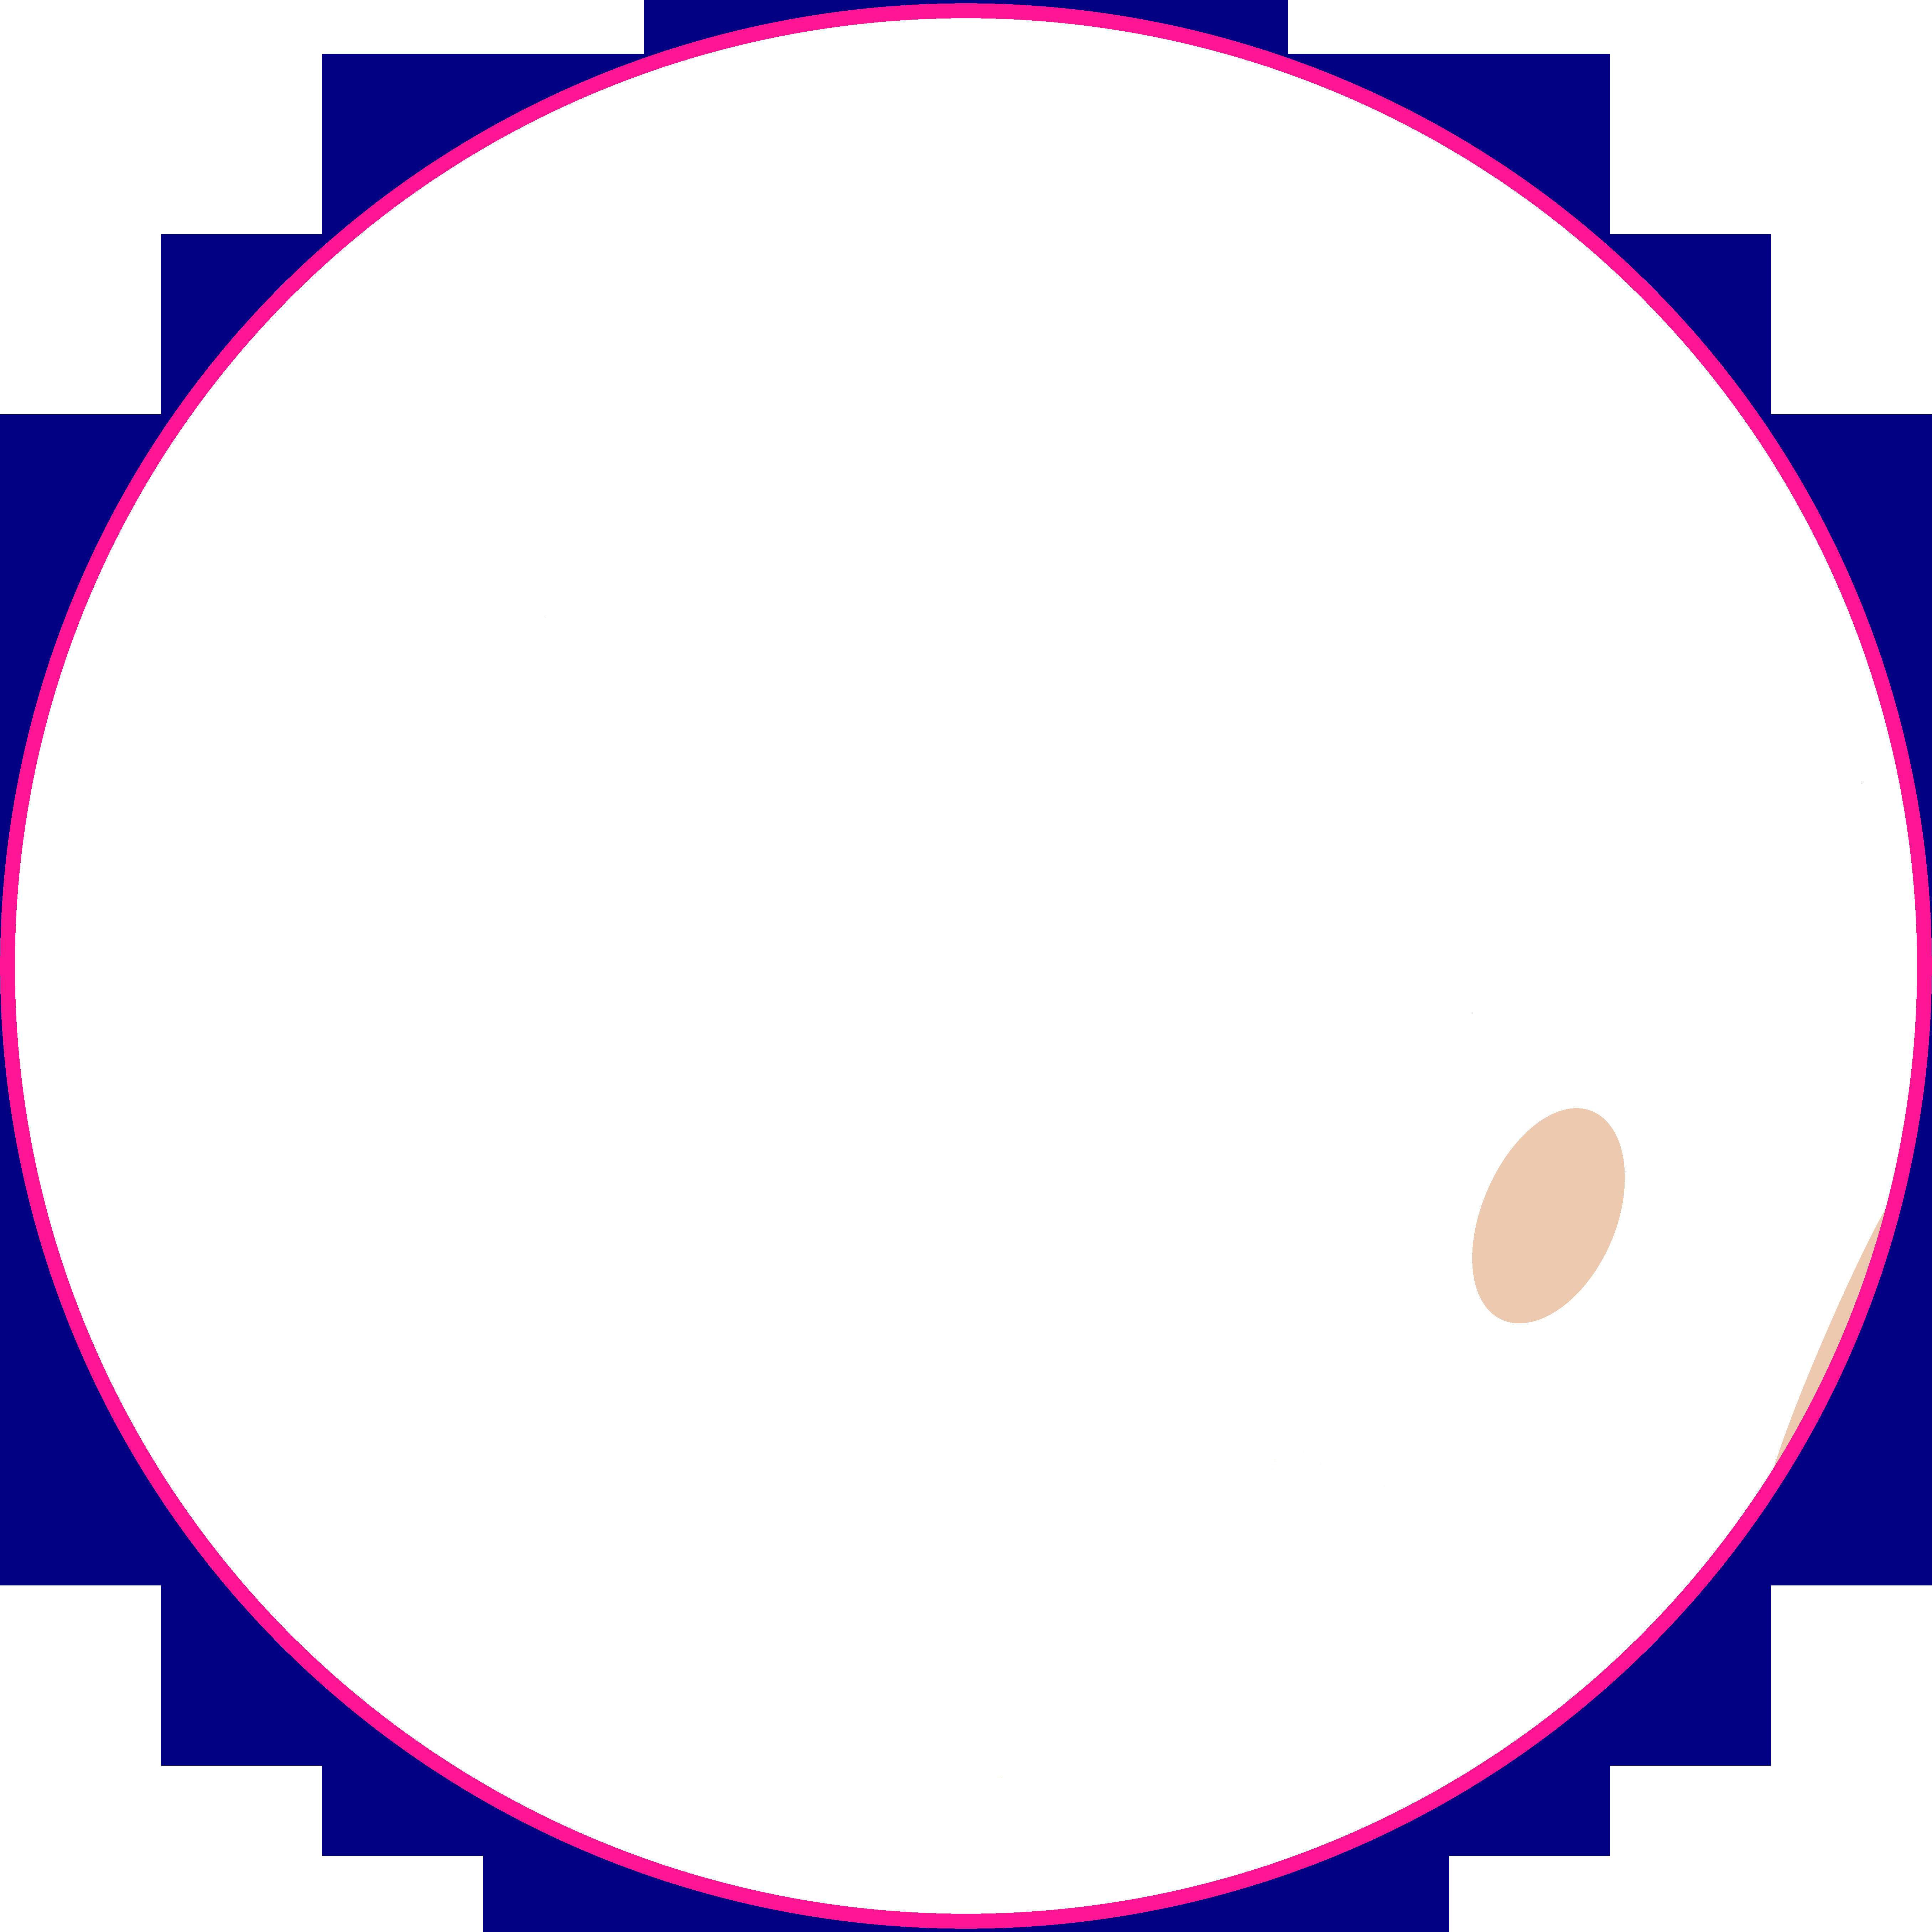

In [12]:
import sys
import numpy as np
import xarray as xr
from satpy import Scene
from trollimage.xrimage import XRImage
from matplotlib.colors import to_rgba
from IPython.display import display, Image

# 1. CARGAR EL ARCHIVO
# Asegúrate de que el nombre del archivo sea el correcto en tu carpeta
filenames = ["OR_ABI-L2-FDCF-M6_G19_s20260031200230_e20260031209539_c20260031210078.nc"]
scn = Scene(reader="abi_l2_nc", filenames=filenames)
scn.load(['Mask'])
mask = scn['Mask']

# 2. DICCIONARIO MAESTRO (31 Categorías)
fdcf_metadata = {
    0:   {'color': '#228B22', 'desc': 'Suelo libre de fuego'},
    10:  {'color': '#8B0000', 'desc': 'Fuego: Alta fidelidad'},
    11:  {'color': '#FF0000', 'desc': 'Fuego: Saturado'},
    12:  {'color': '#FF4500', 'desc': 'Fuego: Tras nubes'},
    13:  {'color': '#FF8C00', 'desc': 'Fuego: Probabilidad alta'},
    14:  {'color': '#FFD700', 'desc': 'Fuego: Probabilidad media'},
    15:  {'color': '#FFFF00', 'desc': 'Fuego: Probabilidad baja'},
    30:  {'color': '#FFFFFF', 'desc': 'Nube detectada'},
    31:  {'color': '#E0FFFF', 'desc': 'Borde de nube'},
    32:  {'color': '#AFEEEE', 'desc': 'Nube probable'},
    33:  {'color': '#ADD8E6', 'desc': 'Nube sin fuego'},
    34:  {'color': '#B0C4DE', 'desc': 'Nube delgada'},
    35:  {'color': '#F0E68C', 'desc': 'Ángulo solar alto'},
    40:  {'color': '#000080', 'desc': 'Cuerpos de agua'},
    50:  {'color': '#FF1493', 'desc': 'Reflejo solar / Glint'},
    60:  {'color': '#EDC9AF', 'desc': 'Desierto'},
    100: {'color': '#556B2F', 'desc': 'Falta L1b'},
    120: {'color': '#808000', 'desc': 'Dato L1b corrupto'},
    121: {'color': '#2F4F4F', 'desc': 'Extremadamente nublado'},
    123: {'color': '#708090', 'desc': 'Fuera de rango térmico'},
    124: {'color': '#A9A9A9', 'desc': 'Error de calibración'},
    125: {'color': '#696969', 'desc': 'Píxel no procesado'},
    126: {'color': '#000000', 'desc': 'Fuera de escaneo'},
    127: {'color': '#1A1A1A', 'desc': 'Valor de relleno'}
}

# IDs que serán transparentes (Alpha = 0)
categorias_transparentes = [30, 31, 32, 33, 34, 35, 100, 120, 121, 123, 124, 125, 126, 127]

# 3. CONSTRUCCIÓN DEL ARRAY RGBA
height, width = mask.shape
rgba_data = np.zeros((4, height, width), dtype=np.float32)

for code, info in fdcf_metadata.items():
    r, g, b, _ = to_rgba(info['color'])
    a = 0.0 if code in categorias_transparentes else 1.0
    
    mask_indices = (mask.values == code)
    rgba_data[0, mask_indices] = r
    rgba_data[1, mask_indices] = g
    rgba_data[2, mask_indices] = b
    rgba_data[3, mask_indices] = a

rgba = xr.DataArray(rgba_data, 
                    coords={'bands': ['R', 'G', 'B', 'A'], 'y': mask.y, 'x': mask.x}, 
                    dims=('bands', 'y', 'x'))

# 4. GENERACIÓN Y VISUALIZACIÓN EN NOTEBOOK (Resolución Real)
img = XRImage(rgba)

# Guardamos temporalmente para forzar la visualización original
temp_out = "temp_fire_mask_fullres.png"
img.save(temp_out)

print(f"📏 Resolución original: {width}x{height} píxeles")
print("👇 Imagen renderizada a tamaño real (usa el scroll si es necesario):")

# display(Image(...)) inserta la imagen tal cual es en la celda
display(Image(filename=temp_out))

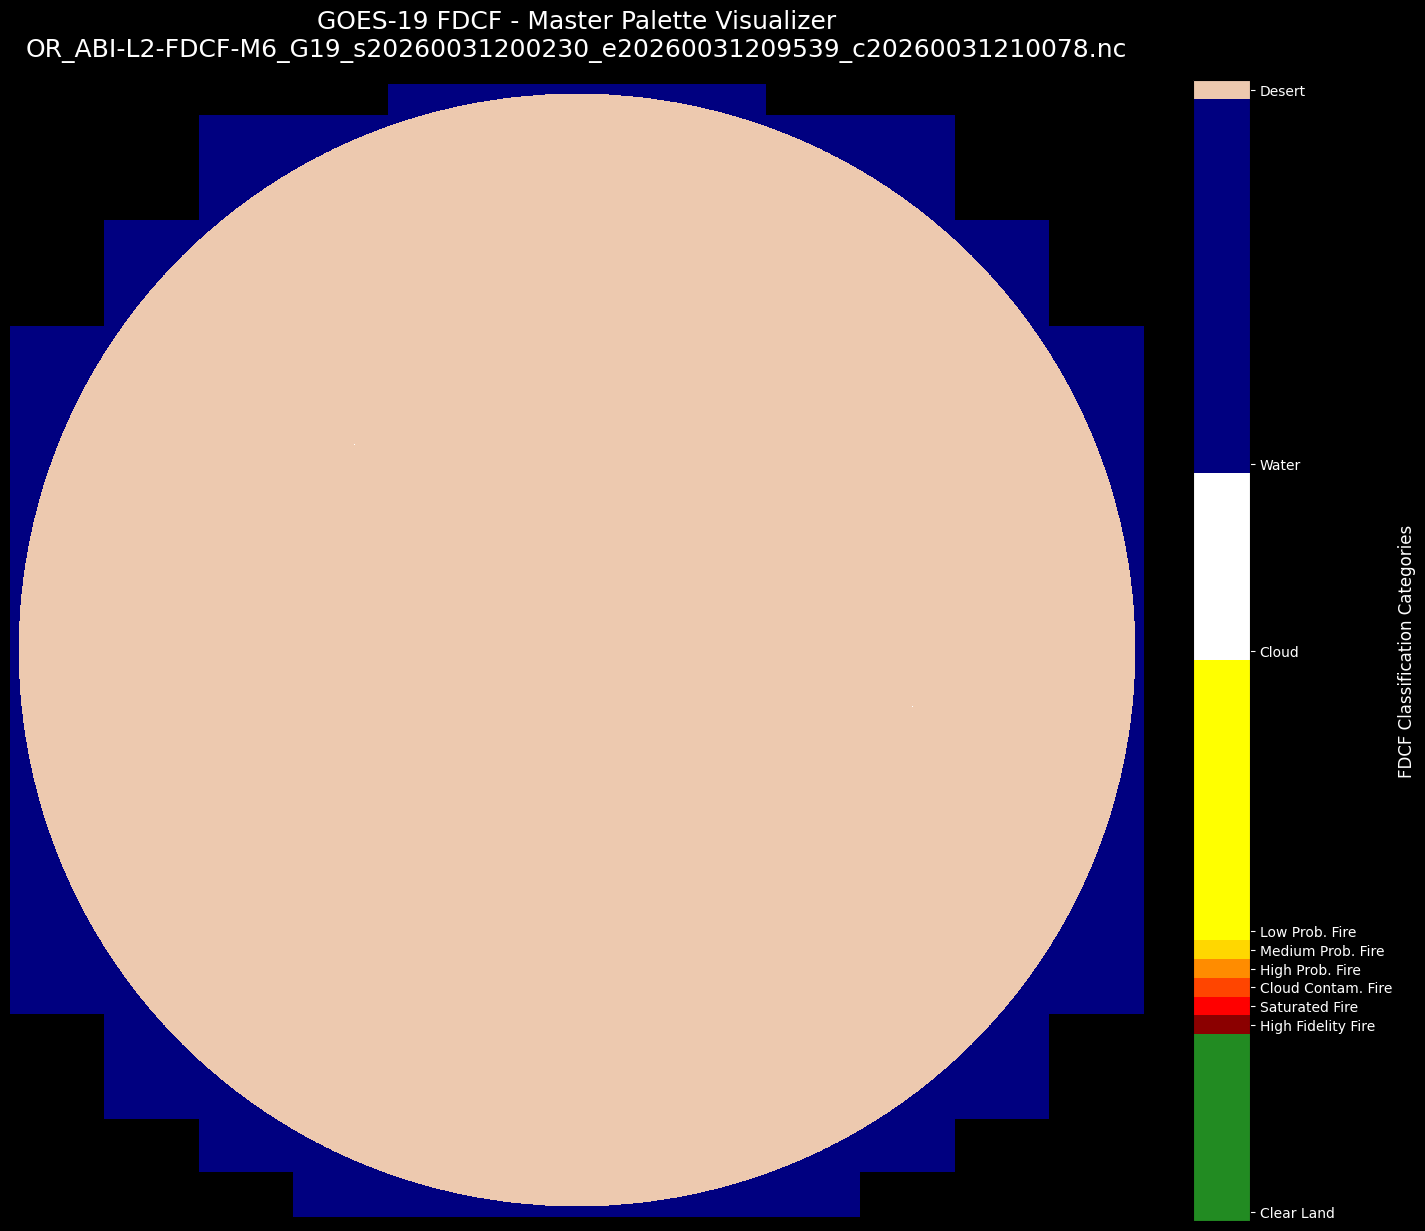

Análisis completado:
 - Focos de calor (fuego) encontrados: 9
🔥 Focos de calor encontrados: <xarray.DataArray 'Mask' ()> Size: 8B
array(9)
Coordinates:
    t                   datetime64[ns] 8B 2026-01-03T12:05:08.498406016
    y_image             float32 4B 0.0
    x_image             float32 4B 0.0
    sunglint_angle      float32 4B 10.0
    local_zenith_angle  float32 4B 80.0
    solar_zenith_angle  float32 4B 10.0
Attributes: (12/17)
    long_name:                                                               ...
    valid_range:                                                             ...
    units:                                                                   ...
    resolution:                                                              ...
    grid_mapping:                                                            ...
    cell_methods:                                                            ...
    ...                                                                 

In [13]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# 1. Cargar el archivo
file_nc = "OR_ABI-L2-FDCF-M6_G19_s20260031200230_e20260031209539_c20260031210078.nc"
ds = xr.open_dataset(file_nc)

# Extraer la máscara y limpiar valores de relleno
mask_full = ds.Mask.astype(float)
mask_full = mask_full.where(mask_full != ds.Mask.attrs.get('_FillValue', 65535))

# 2. DEFINIR CATEGORÍAS Y COLORES (Tu Diccionario)
# Solo incluimos las categorías que queremos que aparezcan en la Colorbar
categories = {
    0:   ('#228B22', 'Clear Land'),
    10:  ('#8B0000', 'High Fidelity Fire'),
    11:  ('#FF0000', 'Saturated Fire'),
    12:  ('#FF4500', 'Cloud Contam. Fire'),
    13:  ('#FF8C00', 'High Prob. Fire'),
    14:  ('#FFD700', 'Medium Prob. Fire'),
    15:  ('#FFFF00', 'Low Prob. Fire'),
    30:  ('#FFFFFF', 'Cloud'),
    40:  ('#000080', 'Water'),
    60:  ('#EDC9AF', 'Desert')
}

# Extraer los IDs, los colores y las etiquetas
ids = sorted(categories.keys())
colors = [categories[i][0] for i in ids]
labels = [categories[i][1] for i in ids]

# 3. CREAR EL COLORMAP Y EL NORM (El "Efecto" que buscas)
# Creamos una paleta discreta
custom_cmap = mcolors.ListedColormap(colors)
# Definimos los límites para que cada ID caiga en su color
norm = mcolors.BoundaryNorm(boundaries=ids + [max(ids)+1], ncolors=len(ids))

# 4. PLOTEAR EL DISCO COMPLETO
plt.figure(figsize=(16, 16), facecolor='black') # Fondo negro para resaltar

im = plt.imshow(mask_full, cmap=custom_cmap, norm=norm, interpolation='nearest')

# 5. CONFIGURAR COLORBAR (Detallando categorías)
cb = plt.colorbar(im, fraction=0.046, pad=0.04, spacing='proportional')
cb.set_label('FDCF Classification Categories', color='white', fontsize=12)

# Ajustar los ticks de la colorbar para que coincidan con los IDs y poner nombres
cb.set_ticks([i + 0.5 for i in ids]) # Centrar el texto en el bloque de color
cb.set_ticklabels(labels, color='white')
cb.ax.tick_params(color='white')

# Título
plt.title(f'GOES-19 FDCF - Master Palette Visualizer\n{ds.attrs.get("dataset_name", "")}', 
          fontsize=18, color='white', pad=20)
plt.axis('off')

plt.show()

# 4. Resumen estadístico
fuegos_detectados = np.sum((mask_full >= 10) & (mask_full <= 15)).values
print(f"Análisis completado:")
print(f" - Focos de calor (fuego) encontrados: {int(fuegos_detectados)}")

# 6. ESTADÍSTICAS
fuegos = np.sum((mask_full >= 10) & (mask_full <= 15))
print(f"🔥 Focos de calor encontrados: {fuegos}")

🔍 Auditoría de Escala Magma (Script 01):
   Rango detectado: 10.0 a 245.0
   ID   0 -> Color RGBA extraído: (np.float64(0.001462), np.float64(0.000466), np.float64(0.013866), np.float64(1.0))
   ID  10 -> Color RGBA extraído: (np.float64(0.001462), np.float64(0.000466), np.float64(0.013866), np.float64(1.0))
   ID  11 -> Color RGBA extraído: (np.float64(0.002258), np.float64(0.001295), np.float64(0.018331), np.float64(1.0))
   ID  12 -> Color RGBA extraído: (np.float64(0.003279), np.float64(0.002305), np.float64(0.023708), np.float64(1.0))
   ID  13 -> Color RGBA extraído: (np.float64(0.004512), np.float64(0.00349), np.float64(0.029965), np.float64(1.0))
   ID  14 -> Color RGBA extraído: (np.float64(0.00595), np.float64(0.004843), np.float64(0.03713), np.float64(1.0))
   ID  15 -> Color RGBA extraído: (np.float64(0.007588), np.float64(0.006356), np.float64(0.044973), np.float64(1.0))
   ID  30 -> Color RGBA extraído: (np.float64(0.060949), np.float64(0.044794), np.float64(0.176129), np

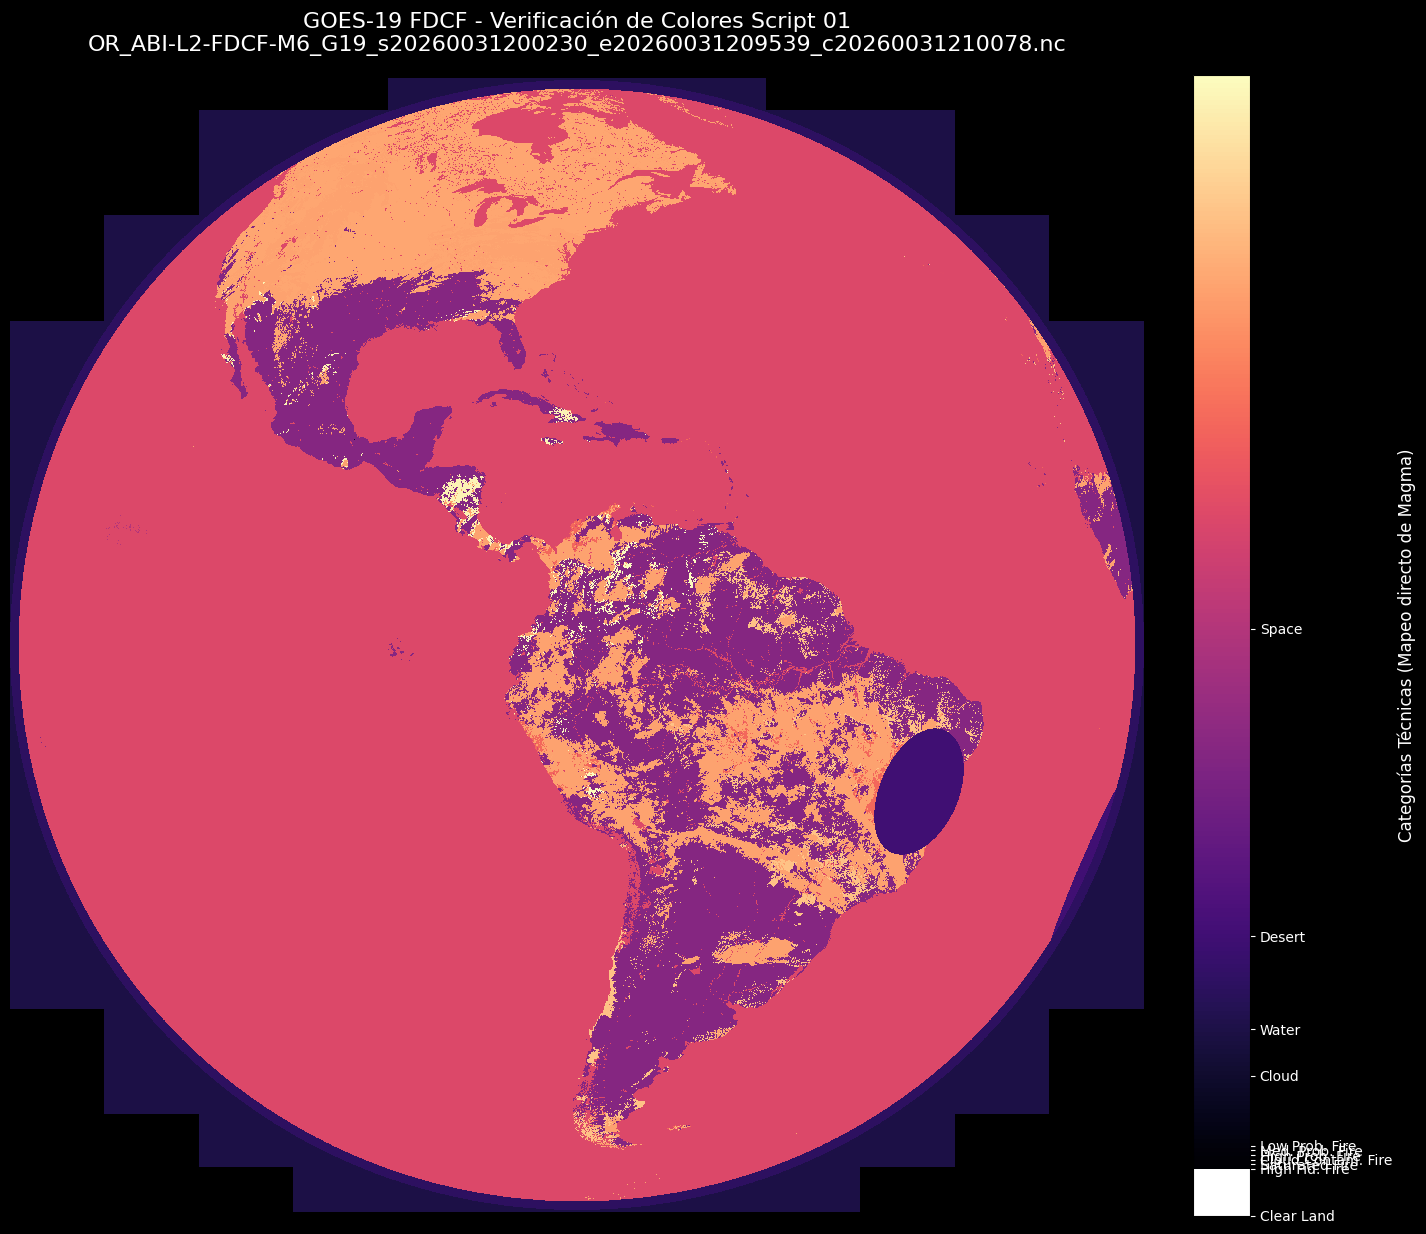

In [14]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

# 1. CARGAR ARCHIVO (Igual al Script 01)
file_nc = "OR_ABI-L2-FDCF-M6_G19_s20260031200230_e20260031209539_c20260031210078.nc"
ds = xr.open_dataset(file_nc)

mask_full = ds.Mask.astype(float)
fill_val = ds.Mask.attrs.get('_FillValue', 65535)
mask_full = mask_full.where(mask_full != fill_val)

# 2. AUDITORÍA DE COLORES (El "corazón" de lo que pides)
# Obtenemos los límites que usa el Script 01 automáticamente
v_min = float(mask_full.min())
v_max = float(mask_full.max())

# Diccionario de categorías que nos interesan
fdcf_labels = {
    0: 'Clear Land', 10: 'High Fid. Fire', 11: 'Saturated Fire', 
    12: 'Cloud Contam. Fire', 13: 'High Prob. Fire', 14: 'Med. Prob. Fire', 
    15: 'Low Prob. Fire', 30: 'Cloud', 40: 'Water', 60: 'Desert', 126: 'Space'
}

print(f"🔍 Auditoría de Escala Magma (Script 01):")
print(f"   Rango detectado: {v_min} a {v_max}")

# Extraemos el color exacto que magma le da a cada categoría
extracted_colors = {}
for code in sorted(fdcf_labels.keys()):
    # Normalización manual que imita a imshow
    val_norm = (code - v_min) / (v_max - v_min)
    # Evitamos valores fuera de rango para el muestreo
    val_norm = np.clip(val_norm, 0, 1)
    color_rgba = cm.magma(val_norm)
    extracted_colors[code] = color_rgba
    print(f"   ID {code:3} -> Color RGBA extraído: {color_rgba}")

# 3. PLOTEO CON LEYENDA DETALLADA
plt.figure(figsize=(16, 16), facecolor='black')

# Usamos la misma configuración que el Script 01
im = plt.imshow(mask_full, cmap='magma', interpolation='nearest')

# 4. COLORBAR PERSONALIZADA BASADA EN LA EXTRACCIÓN
cb = plt.colorbar(im, fraction=0.046, pad=0.04)
cb.set_label('Categorías Técnicas (Mapeo directo de Magma)', color='white', fontsize=12)

# Colocamos los nombres de las categorías donde les toca según Magma
cb.set_ticks(list(fdcf_labels.keys()))
cb.set_ticklabels(list(fdcf_labels.values()), color='white', fontsize=10)
cb.ax.tick_params(color='white')

plt.title(f'GOES-19 FDCF - Verificación de Colores Script 01\n{ds.attrs.get("dataset_name", "")}', 
          fontsize=16, color='white', pad=20)
plt.axis('off')

plt.show()

In [ ]:
extracted_colors

🎨 AUDITORÍA DE COLORES MAGMA (Escala 0-255):
Rango de datos: 10.0 a 245.0
--------------------------------------------------
ID   0 | Clear Land           | RGB: (  0,   0,   3)
ID  10 | High Fid. Fire       | RGB: (  0,   0,   3)
ID  11 | Saturated Fire       | RGB: (  0,   0,   4)
ID  12 | Cloud Contam. Fire   | RGB: (  0,   0,   6)
ID  13 | High Prob. Fire      | RGB: (  1,   0,   7)
ID  14 | Med. Prob. Fire      | RGB: (  1,   1,   9)
ID  15 | Low Prob. Fire       | RGB: (  1,   1,  11)
ID  30 | Cloud                | RGB: ( 15,  11,  44)
ID  40 | Water                | RGB: ( 28,  16,  70)
ID  60 | Desert               | RGB: ( 64,  15, 115)
ID 126 | Space                | RGB: (179,  53, 122)


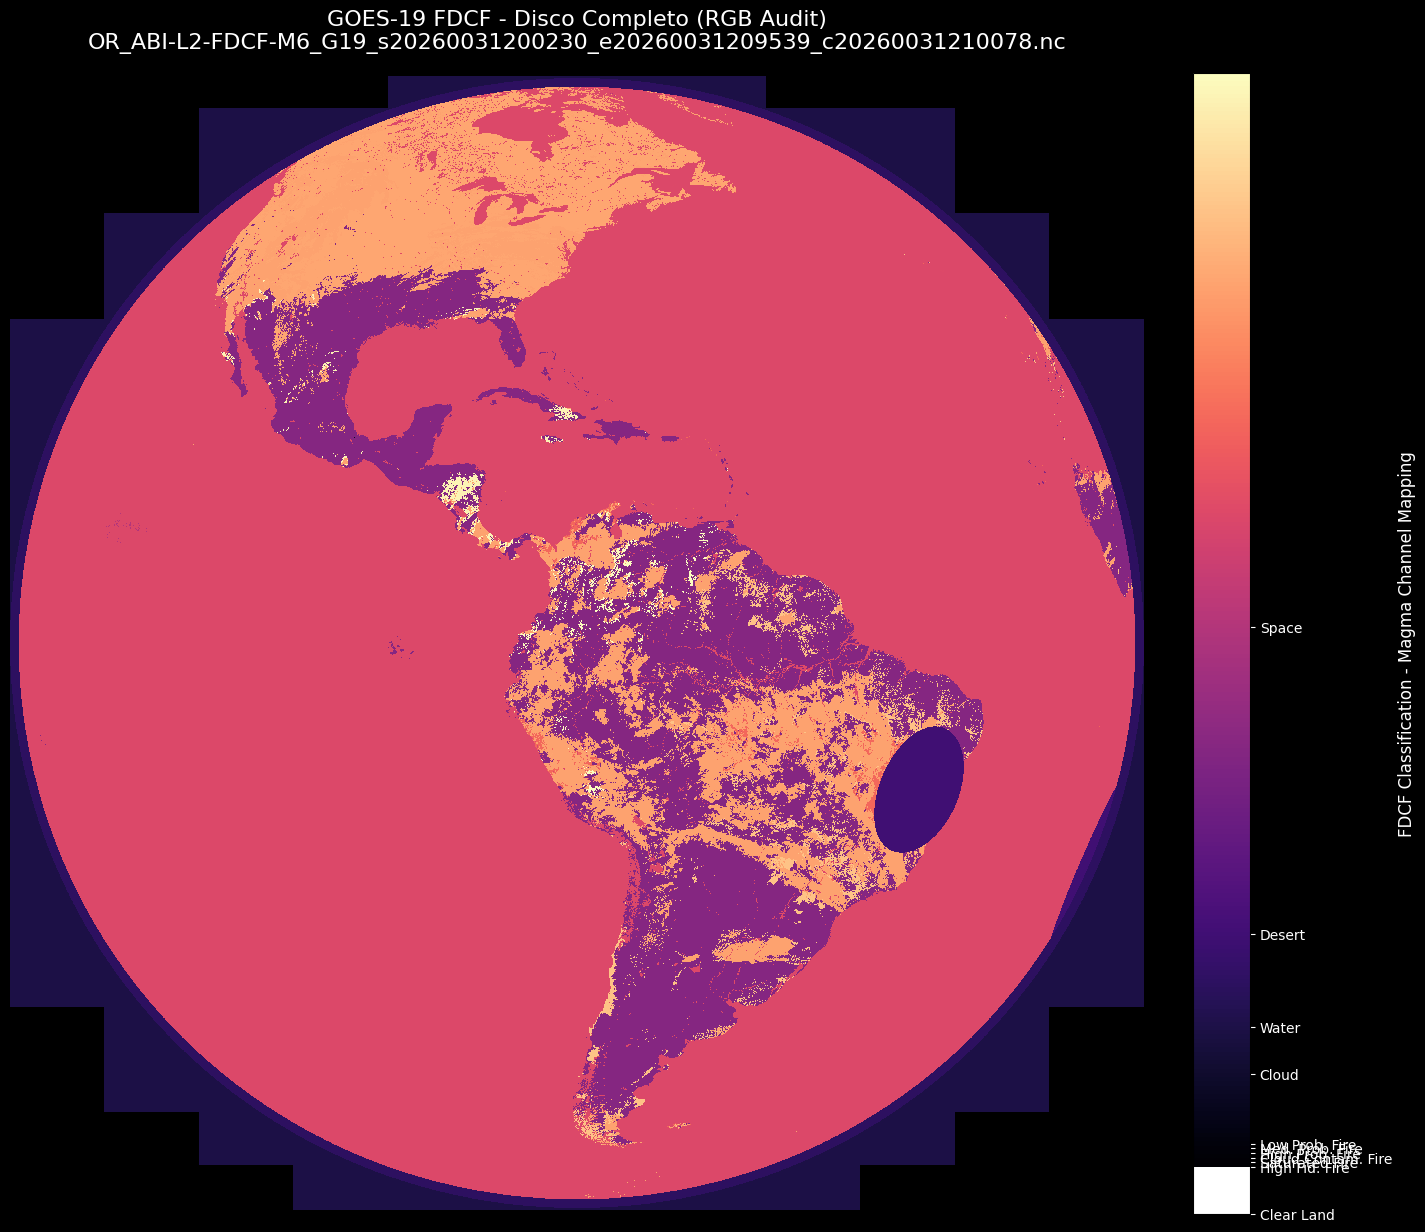

In [15]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

# 1. CARGAR ARCHIVO
file_nc = "OR_ABI-L2-FDCF-M6_G19_s20260031200230_e20260031209539_c20260031210078.nc"
ds = xr.open_dataset(file_nc)

mask_full = ds.Mask.astype(float)
fill_val = ds.Mask.attrs.get('_FillValue', 65535)
mask_full = mask_full.where(mask_full != fill_val)

# 2. AUDITORÍA DE COLORES (Conversión a escala 0-255)
v_min, v_max = float(mask_full.min()), float(mask_full.max())

fdcf_labels = {
    0: 'Clear Land', 10: 'High Fid. Fire', 11: 'Saturated Fire', 
    12: 'Cloud Contam. Fire', 13: 'High Prob. Fire', 14: 'Med. Prob. Fire', 
    15: 'Low Prob. Fire', 30: 'Cloud', 40: 'Water', 60: 'Desert', 126: 'Space'
}

print(f"🎨 AUDITORÍA DE COLORES MAGMA (Escala 0-255):")
print(f"Rango de datos: {v_min} a {v_max}\n" + "-"*50)

for code in sorted(fdcf_labels.keys()):
    # Normalizamos y extraemos de magma
    val_norm = np.clip((code - v_min) / (v_max - v_min), 0, 1)
    rgba_dec = cm.magma(val_norm)
    
    # CONVERSIÓN A 0-255 (Solo R, G, B)
    r, g, b = [int(x * 255) for x in rgba_dec[:3]]
    
    label = fdcf_labels[code]
    print(f"ID {code:3} | {label:20} | RGB: ({r:3}, {g:3}, {b:3})")

# 3. PLOTEO ESTILO "FULL DISK"
plt.figure(figsize=(16, 16), facecolor='black')

im = plt.imshow(mask_full, cmap='magma', interpolation='nearest')

# 4. COLORBAR CON ETIQUETAS TÉCNICAS
cb = plt.colorbar(im, fraction=0.046, pad=0.04)
cb.set_label('FDCF Classification - Magma Channel Mapping', color='white', fontsize=12)

# Ticks y etiquetas
cb.set_ticks(list(fdcf_labels.keys()))
cb.set_ticklabels(list(fdcf_labels.values()), color='white', fontsize=10)
cb.ax.tick_params(color='white')

plt.title(f'GOES-19 FDCF - Disco Completo (RGB Audit)\n{ds.attrs.get("dataset_name", "")}', 
          fontsize=16, color='white', pad=20)
plt.axis('off')

plt.show()

🎨 AUDITORÍA RGB (Valores de los bloques de la barra):
ID   0 -> RGB: (  0,   0,   3) | Clear Land
ID  10 -> RGB: (  0,   0,   3) | High Fid. Fire
ID  11 -> RGB: (  0,   0,   4) | Saturated Fire
ID  12 -> RGB: (  0,   0,   6) | Cloud Contam. Fire
ID  13 -> RGB: (  1,   0,   7) | High Prob. Fire
ID  14 -> RGB: (  1,   1,   9) | Med. Prob. Fire
ID  15 -> RGB: (  1,   1,  11) | Low Prob. Fire
ID  30 -> RGB: ( 15,  11,  44) | Cloud
ID  40 -> RGB: ( 28,  16,  70) | Water
ID  60 -> RGB: ( 64,  15, 115) | Desert
ID 126 -> RGB: (179,  53, 122) | Space


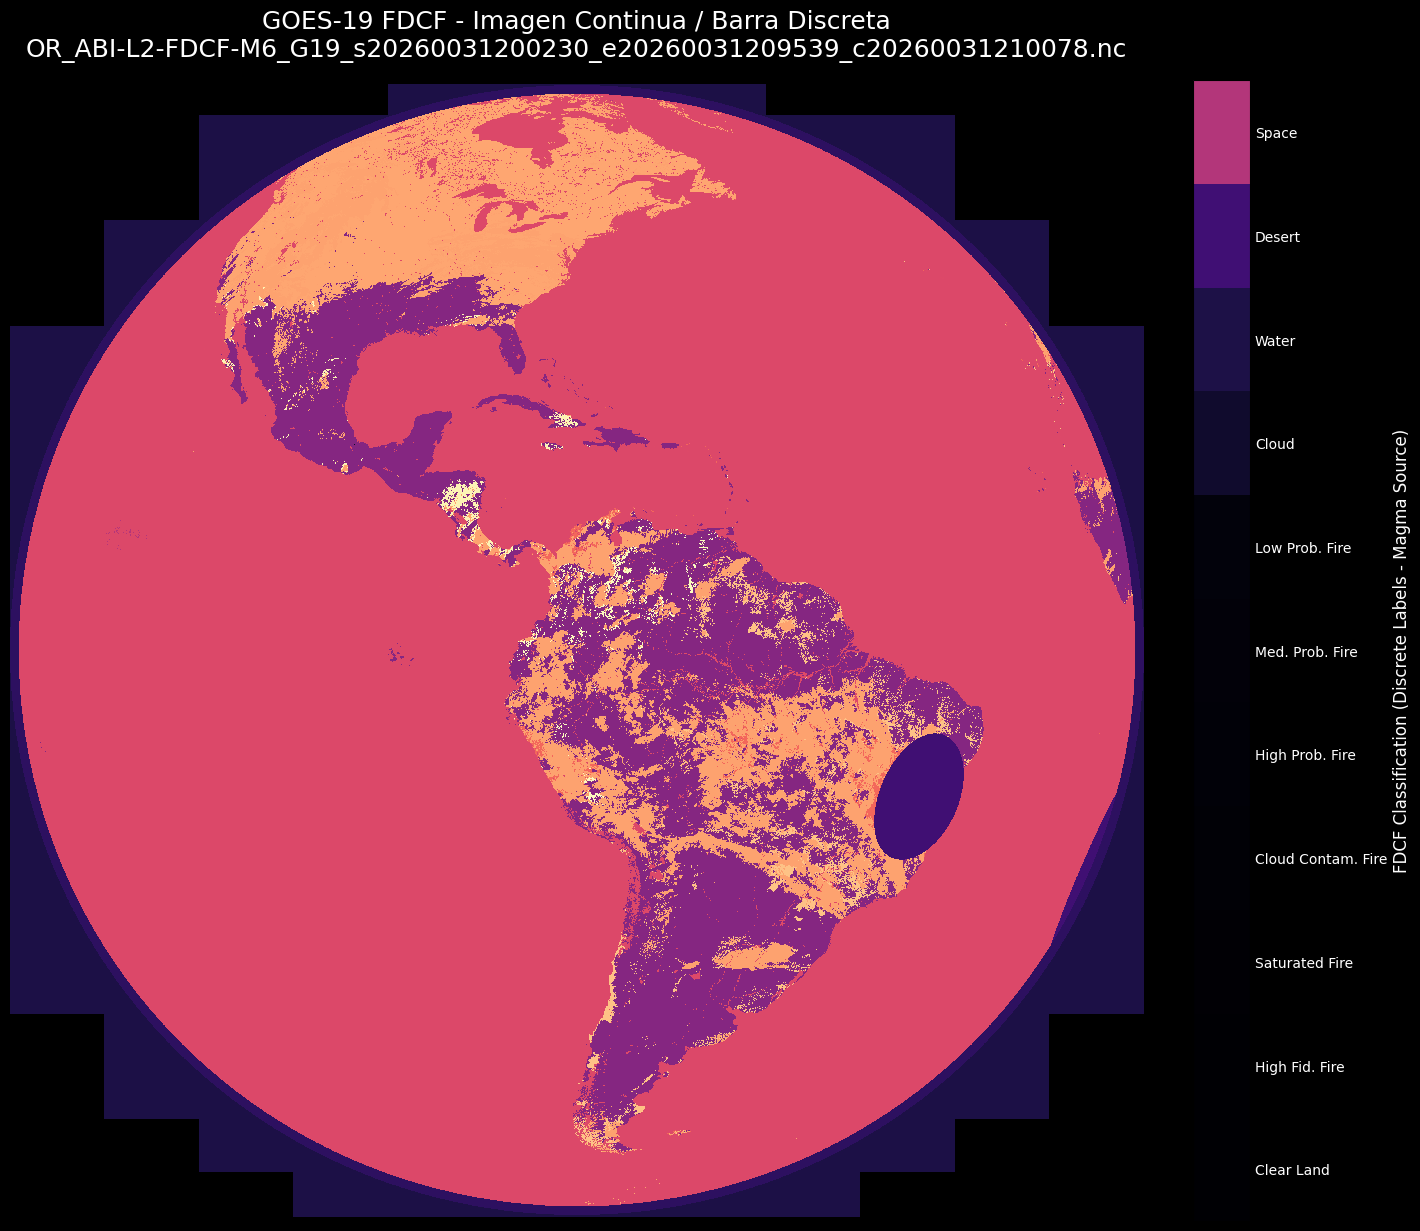

In [18]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
from matplotlib import cm

# 1. CARGAR ARCHIVO
file_nc = "OR_ABI-L2-FDCF-M6_G19_s20260031200230_e20260031209539_c20260031210078.nc"
ds = xr.open_dataset(file_nc)

mask_full = ds.Mask.astype(float)
fill_val = ds.Mask.attrs.get('_FillValue', 65535)
mask_full = mask_full.where(mask_full != fill_val)

# 2. CONFIGURACIÓN TÉCNICA Y EXTRACCIÓN DE COLORES
v_min, v_max = float(mask_full.min()), float(mask_full.max())
norm_original = mcolors.Normalize(vmin=v_min, vmax=v_max)

fdcf_labels = {
    0: 'Clear Land', 10: 'High Fid. Fire', 11: 'Saturated Fire', 
    12: 'Cloud Contam. Fire', 13: 'High Prob. Fire', 14: 'Med. Prob. Fire', 
    15: 'Low Prob. Fire', 30: 'Cloud', 40: 'Water', 60: 'Desert', 126: 'Space'
}
ids = sorted(fdcf_labels.keys())

# Extraemos los colores exactos de Magma para crear una paleta discreta SOLO para la barra
colors_for_cb = [cm.magma(norm_original(i)) for i in ids]
discrete_cmap = mcolors.ListedColormap(colors_for_cb)
discrete_norm = mcolors.BoundaryNorm(np.arange(len(ids) + 1), len(ids))

# 3. PLOTEO (Imagen con Magma Continuo para mantener el brillo)
fig, ax = plt.subplots(figsize=(16, 16), facecolor='black')
im = ax.imshow(mask_full, cmap='magma', norm=norm_original, interpolation='nearest')

# 4. COLORBAR DISCRETA (El cambio clave)
# Creamos un "mappable" invisible que solo sirve para la barra de colores
sm = plt.cm.ScalarMappable(cmap=discrete_cmap, norm=discrete_norm)
sm.set_array([]) # Obligatorio para ScalarMappable

cb = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04, spacing='uniform')
cb.set_label('FDCF Classification (Discrete Labels - Magma Source)', color='white', fontsize=12)

# Posicionamos los nombres en el centro de cada bloque discreto
cb.set_ticks(np.arange(len(ids)) + 0.5)
cb.set_ticklabels([fdcf_labels[i] for i in ids], color='white', fontsize=10)
cb.ax.tick_params(color='white', length=0) # Quitamos las rayitas de los ticks

# 5. AUDITORÍA RGB (0-255)
print(f"🎨 AUDITORÍA RGB (Valores de los bloques de la barra):")
for i, code in enumerate(ids):
    r, g, b = [int(x * 255) for x in colors_for_cb[i][:3]]
    print(f"ID {code:3} -> RGB: ({r:3}, {g:3}, {b:3}) | {fdcf_labels[code]}")

ax.set_title(f'GOES-19 FDCF - Imagen Continua / Barra Discreta\n{ds.attrs.get("dataset_name", "")}', 
             fontsize=18, color='white', pad=20)
ax.axis('off')

plt.show()

ID    | RGB (0-255)     | Descripción
---------------------------------------------------------------------------
0     | (34, 139, 34)   | Suelo libre de fuego y nubes (Area Clear)
10    | (139, 0, 0)     | Fuego de alta fidelidad (Good Quality)
11    | (255, 0, 0)     | Fuego saturado (Saturated - Muy intenso)
12    | (255, 69, 0)    | Fuego detectado a través de nubes delgadas
13    | (255, 140, 0)   | Fuego de alta probabilidad (FRP confiable)
14    | (255, 215, 0)   | Fuego de probabilidad media
15    | (255, 255, 0)   | Fuego de baja probabilidad (Posible falso positivo)
16    | (138, 43, 226)  | Reservado para futuras versiones 1
17    | (128, 0, 128)   | Reservado para futuras versiones 2
18    | (75, 0, 130)    | Reservado para futuras versiones 3
19    | (255, 0, 255)   | Reservado para futuras versiones 4
20    | (218, 112, 214) | Reservado para futuras versiones 5
21    | (221, 160, 221) | Reservado para futuras versiones 6
22    | (216, 191, 216) | Reservado para futuras v

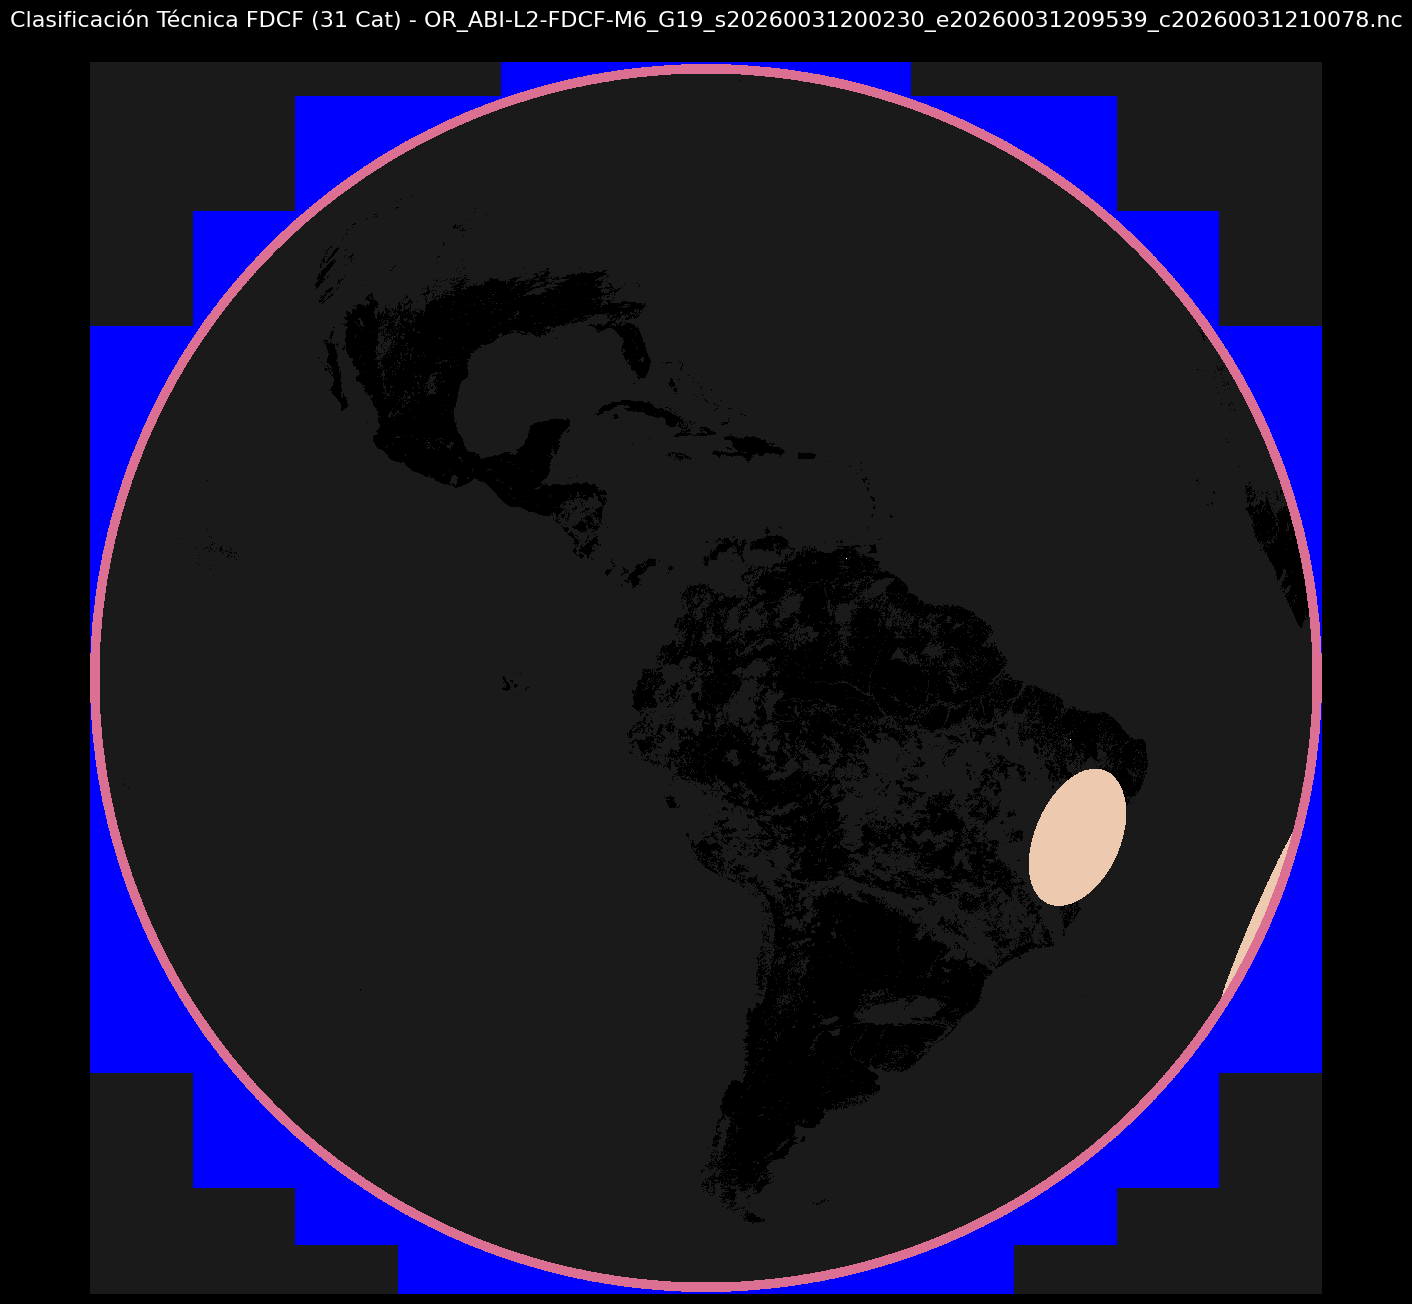

In [20]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import xarray as xr

# 1. Diccionario Maestro COMPLETO (31 Categorías)
fdcf_metadata = {
    # --- GRUPO: SUPERFICIE DESPEJADA ---
    0:   {'color': '#228B22', 'desc': 'Suelo libre de fuego y nubes (Area Clear)'},
    
    # --- GRUPO: DETECCIONES DE FUEGO (CONFIRMADOS) ---
    10:  {'color': '#8B0000', 'desc': 'Fuego de alta fidelidad (Good Quality)'},
    11:  {'color': '#FF0000', 'desc': 'Fuego saturado (Saturated - Muy intenso)'},
    12:  {'color': '#FF4500', 'desc': 'Fuego detectado a través de nubes delgadas'},
    
    # --- GRUPO: DETECCIONES DE FUEGO (PROBABILÍSTICOS) ---
    13:  {'color': '#FF8C00', 'desc': 'Fuego de alta probabilidad (FRP confiable)'},
    14:  {'color': '#FFD700', 'desc': 'Fuego de probabilidad media'},
    15:  {'color': '#FFFF00', 'desc': 'Fuego de baja probabilidad (Posible falso positivo)'},
    
    # --- GRUPO: CATEGORÍAS RESERVADAS (INVESTIGACIÓN) ---
    16:  {'color': '#8A2BE2', 'desc': 'Reservado para futuras versiones 1'},
    17:  {'color': '#800080', 'desc': 'Reservado para futuras versiones 2'},
    18:  {'color': '#4B0082', 'desc': 'Reservado para futuras versiones 3'},
    19:  {'color': '#FF00FF', 'desc': 'Reservado para futuras versiones 4'},
    20:  {'color': '#DA70D6', 'desc': 'Reservado para futuras versiones 5'},
    21:  {'color': '#DDA0DD', 'desc': 'Reservado para futuras versiones 6'},
    22:  {'color': '#D8BFD8', 'desc': 'Reservado para futuras versiones 7'},
    
    # --- GRUPO: NUBOSIDAD (BLOQUEO DE VISIÓN) ---
    30:  {'color': '#FFFFFF', 'desc': 'Nube detectada (Cloud)'},
    31:  {'color': '#F5F5F5', 'desc': 'Borde de nube (Cloud edge)'},
    32:  {'color': '#DCDCDC', 'desc': 'Nube probable (Probable cloud)'},
    33:  {'color': '#E5E4E2', 'desc': 'Nube libre de fuego (Fire-free cloud)'},
    34:  {'color': '#B2BEB5', 'desc': 'Nube delgada (Thin cloud)'},
    35:  {'color': '#F0E68C', 'desc': 'Ángulo solar alto (Dato no confiable)'},
    
    # --- GRUPO: OTRAS SUPERFICIES ---
    40:  {'color': '#0000FF', 'desc': 'Superficie de agua (Cuerpos de agua/Océano)'},
    50:  {'color': '#DB7093', 'desc': 'Reflejo solar detectado (Solar Glint)'},
    60:  {'color': '#EDC9AF', 'desc': 'Superficie desértica (Alta reflectividad)'},
    
    # --- GRUPO: ERRORES E INVÁLIDOS ---
    100: {'color': '#000000', 'desc': 'Dato faltante (Missing L1b)'},
    120: {'color': '#121212', 'desc': 'Dato corrupto (Bad L1b)'},
    121: {'color': '#2F4F4F', 'desc': 'Píxel extremadamente nublado (Inválido)'},
    123: {'color': '#0B0B0B', 'desc': 'Valor fuera de rango (Out of range)'},
    124: {'color': '#0F0F0F', 'desc': 'Error de calibración del sensor'},
    125: {'color': '#050505', 'desc': 'Píxel no procesado por el algoritmo'},
    126: {'color': '#000000', 'desc': 'Fuera del área de escaneo (Espacio)'},
    127: {'color': '#000000', 'desc': 'Valor de relleno (Fill Value)'}
}

# --- PROCESO: AGREGAR CANALES RGB 0-255 AL DICCIONARIO ---
print(f"{'ID':<5} | {'RGB (0-255)':<15} | {'Descripción'}")
print("-" * 75)

for code in sorted(fdcf_metadata.keys()):
    info = fdcf_metadata[code]
    # Conversión HEX -> RGB (0-255)
    rgb_dec = mcolors.to_rgb(info['color'])
    rgb_255 = tuple(int(c * 255) for c in rgb_dec)
    
    # Guardamos en el diccionario
    info['rgb_255'] = rgb_255
    
    print(f"{code:<5} | {str(rgb_255):<15} | {info['desc']}")

# 2. Preparar imagen RGBA (Resolución Nativa)
mask_data = ds.Mask.values
h, w = mask_data.shape
rgba_img = np.zeros((h, w, 4))
rgba_img[:] = mcolors.to_rgba('#1A1A1A') # Fondo base

# 3. Mapeo de Colores
for code, info in fdcf_metadata.items():
    mask_indices = (mask_data == code)
    rgba_img[mask_indices] = mcolors.to_rgba(info['color'])

# 4. Visualización
plt.figure(figsize=(16, 16), facecolor='black')
plt.imshow(rgba_img, interpolation='nearest')
plt.title(f"Clasificación Técnica FDCF (31 Cat) - {ds.attrs.get('dataset_name', 'GOES-19')}", 
          fontsize=16, color='white', pad=25)
plt.axis('off')
plt.show()

In [ ]:
# Ver los metadatos de la variable Mask
print(ds.Mask)

In [19]:
import numpy as np
import xarray as xr
from satpy.enhancements.enhancer import get_enhanced_image

# ... carga del scene scn ...
scn.load(['fdcf_mask'])
data = scn['fdcf_mask']

# 1. EL TRUCO: Reemplazar los NaNs y valores fuera de rango por una categoría de fondo
# En tu script de Matplotlib usabas Magenta, aquí usaremos el ID 40 (Agua/Espacio)
# para que Satpy lo pinte con el color que definas en el YAML.
data_filled = data.where(~np.isnan(data), 40) # Si es NaN, ponle 40
data_filled = data_filled.where(data_filled != 127, 40) # Si es 127 (espacio), ponle 40

# 2. Devolvemos el dato "sólido" al Scene
scn['fdcf_mask'] = data_filled

# 3. Quitamos los atributos que fuerzan la transparencia en el GeoTIFF
if '_FillValue' in scn['fdcf_mask'].attrs:
    del scn['fdcf_mask'].attrs['_FillValue']

# 4. Generar imagen y APLASTAR el canal Alfa
img = get_enhanced_image(scn['fdcf_mask'])
img = img.convert("RGB") # <--- ESTO ELIMINA CUALQUIER RESIDUO DE TRANSPARENCIA

img.save('fuego_final_v001_SIN_TRANSPARENCIA.png')

KeyError: "Unknown datasets: {DataQuery(name='fdcf_mask')}"